# HackerEarth Machine Learning challenge:Calculate the severity of an airplane accident

Flying has been the go-to mode of travel for years now; it is time-saving, affordable, and extremely convenient. According to the FAA, 2,781,971 passengers fly every day in the US, as in June 2019. Passengers reckon that flying is very safe, considering strict inspections are conducted and security measures are taken to avoid and/or mitigate any mishappenings. However, there remain a few chances of unfortunate incidents.

Imagine you have been hired by a leading airline. You are required to build Machine Learning models to anticipate and classify the severity of any airplane accident based on past incidents. With this, all airlines, even the entire aviation industry, can predict the severity of airplane accidents caused due to various factors and, correspondingly, have a plan of action to minimize the risk associated with them.

In [1]:
import numpy as np
import pandas as pd
import os, sys, gc, warnings, random, datetime, math, psutil, time, tqdm, datetime, re, json, copy, shutil, glob
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm as tqdm
%matplotlib inline

from multiprocessing import Pool
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler,LabelEncoder,LabelBinarizer
from sklearn.svm import NuSVR, NuSVC, SVR, SVC, LinearSVC, LinearSVR
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,LabelBinarizer,StandardScaler,QuantileTransformer,MinMaxScaler
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV,RandomizedSearchCV, train_test_split, TimeSeriesSplit
from sklearn import metrics
from sklearn import linear_model
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin

import statsmodels as sm
import scipy as sp

import eli5
import shap
from IPython.display import HTML
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
from typing import List, Any
from numba import jit
from functools import partial
from itertools import product
from collections import defaultdict, Counter

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from bayes_opt import BayesianOptimization

In [2]:
with open('params.json','r') as f:
    param=json.load(f)

In [3]:
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')
submit = pd.read_csv('dataset/sample_submission.csv')

In [4]:
def initial_setup():
    random.seed(param["seed"])
    np.random.seed(param["seed"])
    pd.set_option('max_rows', param['pd']['max_rows'])
    pd.options.display.precision = param['pd']['precision']

In [5]:
def frequency_encoding(uid,columns=param["frequency_encoding"]['columns']):
    try:
        columns = columns[uid]
        for col in tqdm.tqdm_notebook(columns):
            temp_df = pd.concat([train[[col]], test[[col]]])
            fq_encode = temp_df[col].value_counts(dropna=False).to_dict()
            if param['frequency_encoding']["self_encoding"][uid]:
                train[col] = train[col].map(fq_encode)
                test[col]  = test[col].map(fq_encode)
            else:
                train[col+'_fq_enc'] = train[col].map(fq_encode)
                test[col+'_fq_enc']  = test[col].map(fq_encode)
    except:
        pass

In [6]:
# 'columns' and "periods" under 'frequency encoding' are optional in json
def timeblock_frequency_encoding(uid,columns=param["frequency_encoding"]['columns'],periods=param['frequency_encoding']['period_columns']):
    try:
        columns = columns[uid]
        periods = periods[uid]
        for period in tqdm.tqdm_notebook(periods):
            for col in columns:
                new_col = col +'_'+ period
                train[new_col] = train[col].astype(str)+'_'+train[period].astype(str)
                test[new_col]  = test[col].astype(str)+'_'+test[period].astype(str)

                temp_df = pd.concat([train[[new_col]], test[[new_col]]])
                fq_encode = temp_df[new_col].value_counts().to_dict()

                train[new_col] = train[new_col].map(fq_encode)
                test[new_col]  = test[new_col].map(fq_encode)

                if param['frequency_encoding']['only_proportions'][uid]:
                    train[new_col] = train[new_col]/train[period+'_total']
                    test[new_col]  = test[new_col]/test[period+'_total']

                if param['frequency_encoding']['with_proportions'][uid]:
                    train[new_col+'_proportions'] = train[new_col]/train[period+'_total']
                    test[new_col+'_proportions']  = test[new_col]/test[period+'_total']
    except:
        pass

In [7]:
# 'main_columns' and 'uids' under 'agg' in json file are optional
def uid_aggregation_and_normalization(uid,main_columns=param['agg']['main_columns'],uids=param['agg']['uids']):
    try:
        main_columns = main_columns[uid]
        uids = uids[uid]
        for main_column in tqdm.tqdm_notebook(main_columns):  
            for col in uids:
                if param['agg']['normalize'][uid]:
                    new_norm_col_name = col+'_'+main_column+'_std_norm'
                    norm_cols = []

                for agg_type in param['agg']['aggregations'][uid]:
                    new_col_name = col+'_'+main_column+'_'+agg_type
                    temp_df = pd.concat([train[[col, main_column]], test[[col,main_column]]])
                    temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(columns={agg_type: new_col_name})

                    temp_df.index = list(temp_df[col])
                    temp_df = temp_df[new_col_name].to_dict()   

                    train[new_col_name] = train[col].map(temp_df)
                    test[new_col_name]  = test[col].map(temp_df)
                    if param['agg']['normalize'][uid]:
                        norm_cols.append(new_col_name)
                if param['agg']['normalize'][uid]:
                    train[new_norm_col_name] = (train[main_column]-train[norm_cols[0]])/train[norm_cols[1]]
                    test[new_norm_col_name]  = (test[main_column]-test[norm_cols[0]])/test[norm_cols[1]]          
                    del train[norm_cols[0]], train[norm_cols[1]]
                    del test[norm_cols[0]], test[norm_cols[1]]
    except:
        pass

In [8]:
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)
        
    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 
        
    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]
    
    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)
    
    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)
        
    size_scale = kwargs.get('size_scale', 500)
    
    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}
    
    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}
    
    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot
        
    marker = kwargs.get('marker', 's')
    
    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}
    
    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')
    
    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = y[1] - y[0]
        ax.barh(
            y=y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(y), max(y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 

def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [9]:
def remove_via_corr(uid,new_columns,original_columns):
    try:
        best_fe_columns = []
        for col in new_columns:
            best_option = ''
            best_cof = param['thresholds']['corr_columns'][uid]
            best_cof_target = param['thresholds']['corr_target'][uid]
            cor_cof = np.corrcoef(train[param['target']], train[col].fillna(0))[0][1]
            if cor_cof > best_cof_target:
                flag=True
                for m_col in original_columns:
                    cor_cof = np.corrcoef(train[m_col], train[col].fillna(0))[0][1]
                    cor_cof = (cor_cof**2)**0.5
                    if cor_cof > best_cof:
                        flag=False      
                        break
                if flag:
                    best_fe_columns.append(col)

        for col in new_columns:
            if col not in best_fe_columns:
                del train[col], test[col]
    except:
        pass

In [10]:
def add_datepart(df: pd.DataFrame, field_name: str,
                 prefix: str = None, drop: bool = True, time: bool = True, date: bool = True):
    """
    Helper function that adds columns relevant to a date in the column `field_name` of `df`.
    from fastai: https://github.com/fastai/fastai/blob/master/fastai/tabular/transform.py#L55
    """
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Is_month_end', 'Is_month_start']
    if date:
        attr.append('Date')
    if time:
        attr = attr + ['Hour', 'Minute']
    for n in attr:
        df[prefix + n] = getattr(field.dt, n.lower())
    if drop:
        df.drop(field_name, axis=1, inplace=True)
    return df

In [11]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [12]:
def df_parallelize_run(df, func):
    num_partitions, num_cores = psutil.cpu_count(), psutil.cpu_count()  # number of partitions and cores
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [13]:
def check_state():
    pass

In [14]:
def get_unique(train,col,test=None):
    s = set()
    s.update(train[col].unique())
    if type(test) == pd.DataFrame:
        s.update(test[col].unique())
    return list(s),len(list(s))

In [15]:
def get_enc(classes,mode=0):
    if mode == 0:
        enc = LabelEncoder()
        enc.fit(classes)
    if mode == 1:
        enc = LabelBinarizer()
        enc.fit(classes)
    elif mode == 2:
        enc=StandardScaler()
        enc.set_params(**param["standardize_cols_params"]["params"])
        enc.fit(classes)
    elif mode == 3:
        enc=QuantileTransformer()
        enc.set_params(**param["quantile_transform_cols_params"]["params"])
        enc.fit(classes)
    return enc

In [16]:
def is_permitted(col,i):
    columns = param['id_columns'][i] + param['neglect_encoding'][i] + param['date_columns'][i] + param['target']
    if col not in columns:
        return True
    else:
        return False

In [17]:
def standardize_encoding(train,col,test,enc=None,replace=param['standardize_cols_params']['replace'],drop=param['standardize_cols_params']['drop'],suffix='x'):
    if not enc:
        enc = get_enc(train[col].values.reshape(-1,1),2)
    if replace:
        train[col] = enc.transform(train[col].values.reshape(-1,1))
        if type(test) == pd.DataFrame:
            test[col] = enc.transform(test[col].values.reshape(-1,1))
    else:
        train[col+'_'+suffix] = enc.transform(train[col].values.reshape(-1,1))
        if type(test) == pd.DataFrame:
            test[col+'_'+suffix] = enc.transform(test[col].values.reshape(-1,1))
    if drop:
        train.drop(col,axis=1,inplace=True)
        if type(test) == pd.DataFrame:
            test.drop(col,axis=1,inplace=True)
    return enc

In [18]:
def quantile_encoding(train,col,test,enc=None,replace=param['quantile_transform_cols_params']['replace'],drop=param['quantile_transform_cols_params']['drop'],suffix='x'):
    if not enc:
        enc = get_enc(train[col].values.reshape(-1,1),3)
    if replace:
        train[col] = enc.transform(train[col].values.reshape(-1,1))
        if type(test) == pd.DataFrame:
            test[col] = enc.transform(test[col].values.reshape(-1,1))
    else:
        train[col+'_'+suffix] = enc.transform(train[col].values.reshape(-1,1))
        if type(test) == pd.DataFrame:
            test[col+'_'+suffix] = enc.transform(test[col].values.reshape(-1,1))
    if drop:
        train.drop(col,axis=1,inplace=True)
        if type(test) == pd.DataFrame:
            test.drop(col,axis=1,inplace=True)
    return enc

In [19]:
def one_hot_encoding(train,col,test,enc=None,drop=param['ohe_cat_cols_params']['drop']):
    if not enc:
        enc = get_enc(get_unique(train,col,test)[0],1)
    tr = enc.transform(train[col])
    if type(test) == pd.DataFrame:
        te = enc.transform(test[col])
    for i in range(len(enc.classes_)):
        if type(test) == pd.DataFrame:
            test[col+'_'+str(i)] = te[:,i]
        train[col+'_'+str(i)] = tr[:,i]
    if drop:
        train.drop(col,axis=1,inplace=True)
        if type(test) == pd.DataFrame:
            test.drop(col,axis=1,inplace=True)
    return enc

In [20]:
def label_encoding(train,col,test,enc=None,replace=param['le_cat_cols_params']['replace'],drop=param['le_cat_cols_params']['drop'],suffix='x'):
    if not enc:
        enc = get_enc(get_unique(train,col,test)[0],0)
    if replace:
        train[col] = enc.transform(train[col])
        if type(test) == pd.DataFrame:
            test[col] = enc.transform(test[col])
    else:
        train[col+'_'+suffix] = enc.transform(train[col])
        if type(test) == pd.DataFrame:
            test[col+'_'+suffix] = enc.transform(test[col])
    if drop:
        train.drop(col,axis=1,inplace=True)
        if type(test) == pd.DataFrame:
            test.drop(col,axis=1,inplace=True)
    return enc

In [21]:
def encode(uid):
    def drive(train,test,i):
        encs = []
        if param['ohe_cat_cols'][i]:
            for col in tqdm.tqdm_notebook(param['ohe_cat_cols'][i]):
                encs.append(one_hot_encoding(train,col,test))
        elif param['thresholds']['ohe'][i]:
            for col in tqdm.tqdm_notebook(train.columns):
                s,l = get_unique(train,col,test)
                if l <= param['thresholds']['ohe'][i][1] and l >= param['thresholds']['ohe'][i][0] and is_permitted(col,i):
                    enc = get_enc(s,mode=1)
                    one_hot_encoding(train,col,test,enc)
                    encs.append(enc)
        if param['le_cat_cols'][i]:
            for col in tqdm.tqdm_notebook(param['le_cat_cols'][i]):
                encs.append(label_encoding(train,col,test))
        elif param['thresholds']['le'][i]:
            for col in tqdm.tqdm_notebook(train.columns):
                s,l = get_unique(train,col,test)
                if l <= param['thresholds']['le'][i][1] and l >= param['thresholds']['le'][i][0] and is_permitted(col,i):
                    enc = get_enc(s,mode=0)
                    label_encoding(train,col,test,enc)
                    encs.append(enc)
        if param['quantile_transform_cols'][i]:
            for col in tqdm.tqdm_notebook(param['quantile_transform_cols'][i]):
                encs.append(quantile_encoding(train,col,test))
        elif param['thresholds']['qt'][i]:
            for col in tqdm.tqdm_notebook(train.columns):
                s,l = get_unique(train,col,test)
                if l <= param['thresholds']['qt'][i][1] and l >= param['thresholds']['qt'][i][0] and is_permitted(col,i):
                    enc = get_enc(s,mode=3)
                    quantile_encoding(train,col,test,enc)
                    encs.append(enc)
        if param['standardize_cols'][i]:
            for col in tqdm.tqdm_notebook(param['standardize_cols'][i]):
                encs.append(standardize_encoding(train,col,test))
        elif param['thresholds']['sc'][i]:
            for col in tqdm.tqdm_notebook(train.columns):
                s,l = get_unique(train,col,test)
                if l <= param['thresholds']['sc'][i][1] and l >= param['thresholds']['sc'][i][0] and is_permitted(col,i):
                    enc = get_enc(s,mode=2)
                    standardize_encoding(train,col,test,enc)
                    encs.append(enc)
        return encs
    try:
        return drive(train,test,uid)
    except e:
        return []

In [22]:
def to_datetime(uid):
    def drive(train,test,i):
        if param['date_columns'][i]:
            for col in tqdm.tqdm_notebook(param['date_columns'][i]):
                train[col] = pd.to_datetime(train[col])
                if type(test) == pd.DataFrame:
                    test[col] = pd.to_datetime(test[col])
    try:
        drive(train,test,uid)
    except:
        pass

In [23]:
def to_drop(uid):
    def drive(train,test,i):
        if param['to_drop'][i]:
            train.drop(param['to_drop'][i],axis=1,inplace=True)
            if type(test) == pd.DataFrame:
                test.drop(param['to_drop'][i],axis=1,inplace=True)
    try:
        drive(train,test,uid)
    except:
        pass

In [24]:
def log_features(uid):
    def drive(train,test,i):
        if param['log_features'][i] is not None:
            for col in tqdm.tqdm_notebook(param['log_features'][i]):
                train[col] = np.log1p(train[col])
                if type(test) == pd.DataFrame:
                    test[col] = np.log1p(test[col])
    try:
        drive(train,test,uid)
    except:
        pass

In [25]:
def exp_features(uid):
    def drive(train,test,i):
        if param['exp_features'][i] is not None:
            for col in tqdm.tqdm_notebook(param['exp_features'][i]):
                train[col] = np.expm1(train[col])
                if type(test) == pd.DataFrame:
                    test[col] = np.expm1(test[col])
    try:
        drive(train,test,uid)
    except:
        pass

In [26]:
def pow_features(uid):
    def drive(train,test,i):
        if param['pow_features'][i] is not None:
            for col,val in tqdm.tqdm_notebook(param['pow_features'][i].items()):
                if val[1] is not None:
                    train[f'{col}{val[1]}'] = train[col] ** val[0]
                    if type(test) == pd.DataFrame:
                        test[f'{col}{val[1]}'] = test[col] ** val[0]
                else:
                    train[col] = train[col] ** val[0]
                    if type(test) == pd.DataFrame:
                        test[col] = test[col] ** val[0]
    try:
        drive(train,test,uid)
    except:
        pass

In [27]:
def add_features(uid):
    def drive(train,test,i):
        if param['add_features'][i] is not None:
            for col,val in tqdm.tqdm_notebook(param['add_features'][i].items()):
                if type(val) == str:
                    if val == 'min':
                        val = train[col].min()
                    elif val == 'max':
                        val = train[col].max()
                train[col] = train[col] + val
                if type(test) == pd.DataFrame:
                    test[col] = test[col] + val
    try:
        drive(train,test,uid)
    except:
        pass

In [28]:
def mul_features(uid):
    def drive(train,test,i):
        if param['mul_features'][i] is not None:
            for col,val in tqdm.tqdm_notebook(param['mul_features'][i].items()):
                if type(val) == str:
                    if val == 'min':
                        val = train[col].min()
                    elif val == 'max':
                        val = train[col].max()
                train[col] = train[col] * val
                if type(test) == pd.DataFrame:
                    test[col] = test[col] * val
    try:
        drive(train,test,uid)
    except:
        pass

In [29]:
def sub_features(uid):
    def drive(train,test,i):
        if param['sub_features'][i] is not None:
            for col,val in tqdm.tqdm_notebook(param['sub_features'][i].items()):
                if type(val[0]) == str:
                    if val[0] == 'min':
                        val[0] = train[col].min()
                    elif val[0] == 'max':
                        val[0] = train[col].max()
                print(val[0])
                if val[1] == 0:
                    train[col] = train[col] - val[0]
                    if type(test) == pd.DataFrame:
                        test[col] = test[col] - val[0]
                elif val[1] == 1:
                    train[col] = val[0] - train[col]
                    if type(test) == pd.DataFrame:
                        test[col] = val[0] - test[col]
    try:
        drive(train,test,uid)
    except:
        pass

In [30]:
def div_features(uid):
    def drive(train,test,i):
        if param['div_features'][i] is not None:
            for col,val in tqdm.tqdm_notebook(param['div_features'][i].items()):
                if type(val[0]) == str:
                    if val[0] == 'min':
                        val[0] = train[col].min()
                    elif val[0] == 'max':
                        val[0] = train[col].max()
                print(val[0])
                if val[1] == 0:
                    train[col] = train[col] / val[0]
                    if type(test) == pd.DataFrame:
                        test[col] = test[col] / val[0]
                elif val[1] == 1:
                    train[col] = val[0] / train[col]
                    if type(test) == pd.DataFrame:
                        test[col] = val[0] / test[col]
    try:
        drive(train,test,uid)
    except:
        pass

In [31]:
class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)
    
class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in col
                                          or 'mean' in col or 'max' in col or 'std' in col
                                          or 'attempt' in col]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]

        if self.convert_cyclical:
            data['timestampHour'] = np.sin(2 * np.pi * data['timestampHour'] / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestampMonth'] / 23.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestampWeek'] / 23.0)
            data['timestampMinute'] = np.sin(2 * np.pi * data['timestampMinute'] / 23.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)
    
    
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
#         print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
#             print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [32]:
# data cleaning
def get_data(user_sample, test_set=False):
    pass

def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    for i, (ins_id, user_sample) in tqdm.tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data = get_data(user_sample, test_set = True)
        compiled_test.append(test_data)
    reduce_train = pd.DataFrame(compiled_train)
    reduce_test = pd.DataFrame(compiled_test)
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [33]:
def get_columns_from_importances(imp):
    s = str(train.columns[imp<=param['thresholds']['feature_importance']].values)
    s = s.replace('\n','')
    s = s.replace(' ',',')
    s = s.replace("[","")
    s = s.replace("]","")
    s = s.replace("\'","\"")
    return s

In [34]:
# feature engineering
def preprocess(uid):
#     train.Cabin_Temperature = (train.Cabin_Temperature - 32) * 5/9
#     test.Cabin_Temperature = (test.Cabin_Temperature - 32) * 5/9
    global train
    global test
    indexes = range(0,10000)
    for col in ['Safety_Score', 'Days_Since_Inspection',
           'Total_Safety_Complaints', 'Control_Metric', 'Turbulence_In_gforces',
           'Cabin_Temperature', 'Accident_Type_Code', 'Max_Elevation',
           'Violations', 'Adverse_Weather_Metric']:
        zscore = (train[col] - train[col].mean())/train[col].std(ddof=0)
        zscore[zscore<param['thresholds']['zscore']] = 1
        zscore[zscore>=param['thresholds']['zscore']] = 0
        indexes = np.intersect1d(indexes,zscore[zscore==1].index)
    train = train.iloc[indexes]
    train['total'] = train.Total_Safety_Complaints + train.Days_Since_Inspection
    test['total'] = test.Total_Safety_Complaints + test.Days_Since_Inspection
    train['total2'] = train.Safety_Score + train.Control_Metric
    test['total2'] = test.Safety_Score + test.Control_Metric
    train['total3'] = train.Max_Elevation + train.Turbulence_In_gforces + train.Cabin_Temperature
    test['total3'] = test.Max_Elevation + test.Turbulence_In_gforces + test.Cabin_Temperature
    print("Adding...")
    add_features(uid)
    print("Subtracting...")
    sub_features(uid)
    print("Dividing...")
    div_features(uid)
    print("Multiplying...")
    mul_features(uid)
    print("Logging...")
    log_features(uid)
    print("Exponential...")
    exp_features(uid)
    print("Polynomial Features...")
    pow_features(uid)
    print("Encoding...")
    encs = encode(uid)
    print("Frequency Encoding...")
    frequency_encoding(uid)
    uid_aggregation_and_normalization(uid=0)
    # uid_aggregation_and_normalization(uid=1)
    return encs

In [35]:
initial_setup()

In [36]:
outputs = {'Accident_ID':test.Accident_ID,'Severity':[]}

In [37]:
train = reduce_mem_usage(train,False)
test = reduce_mem_usage(test,False)

## Dataset Explanation

The dataset consists of certain parameters recorded during the incident⁠ such as cabin temperature, turbulence experienced, number of safety complaints prior to the accident, number of days since the last inspection was conducted before the incident, an estimation of the pilot’s control given the various factors at play, and the likes. 

In [38]:
target = train.Severity

In [39]:
train.head()

Severity  Safety_Score  \
0                Minor_Damage_And_Injuries        49.224   
1                Minor_Damage_And_Injuries        62.466   
2        Significant_Damage_And_Fatalities        63.059   
3  Significant_Damage_And_Serious_Injuries        48.082   
4        Significant_Damage_And_Fatalities        26.484   

   Days_Since_Inspection  Total_Safety_Complaints  Control_Metric  \
0                     14                       22          71.285   
1                     10                       27          72.288   
2                     13                       16          66.363   
3                     11                        9          74.704   
4                     13                       25          47.949   

   Turbulence_In_gforces  Cabin_Temperature  Accident_Type_Code  \
0                  0.272              78.04                   2   
1                  0.424              84.54                   2   
2                  0.323              78.86                   7   
3                  0.337              81.79                   3   
4                  0.541              77.16                   3   

   Max_Elevation  Violations  Adverse_Weather_Metric  Accident_ID  
0      31335.477           3                   0.424         7570  
1      26024.711           2                   0.352        12128  
2      39269.054           3                   0.003         2181  
3      42771.499           1                   0.212         5946  
4      35509.229           2                   0.177         9054

In [40]:
test.head()

Safety_Score  Days_Since_Inspection  Total_Safety_Complaints  \
0        19.498                     16                        6   
1        58.174                     15                        3   
2        33.288                     15                        3   
3         3.288                     21                        5   
4        10.868                     18                        2   

   Control_Metric  Turbulence_In_gforces  Cabin_Temperature  \
0          72.151                  0.389              78.32   
1          64.585                  0.251              78.60   
2          64.722                  0.337              86.96   
3          66.363                  0.422              80.86   
4          56.108                  0.313              79.22   

   Accident_Type_Code  Max_Elevation  Violations  Adverse_Weather_Metric  \
0                   4      37949.724           2                   0.070   
1                   7      30194.806           2                   0.003   
2                   6      17572.925           1                   0.004   
3                   3      40209.186           2                   0.200   
4                   2      35495.525           2                   0.484   

   Accident_ID  
0            1  
1           10  
2           14  
3           17  
4           21

In [41]:
submit.head()

Accident_ID                                 Severity
0            1                Minor_Damage_And_Injuries
1           10                Highly_Fatal_And_Damaging
2           14                Highly_Fatal_And_Damaging
3           17  Significant_Damage_And_Serious_Injuries
4           21                Minor_Damage_And_Injuries

In [42]:
target.nunique()

4

In [43]:
target.value_counts()

Highly_Fatal_And_Damaging                  3049
Significant_Damage_And_Serious_Injuries    2729
Minor_Damage_And_Injuries                  2527
Significant_Damage_And_Fatalities          1695
Name: Severity, dtype: int64

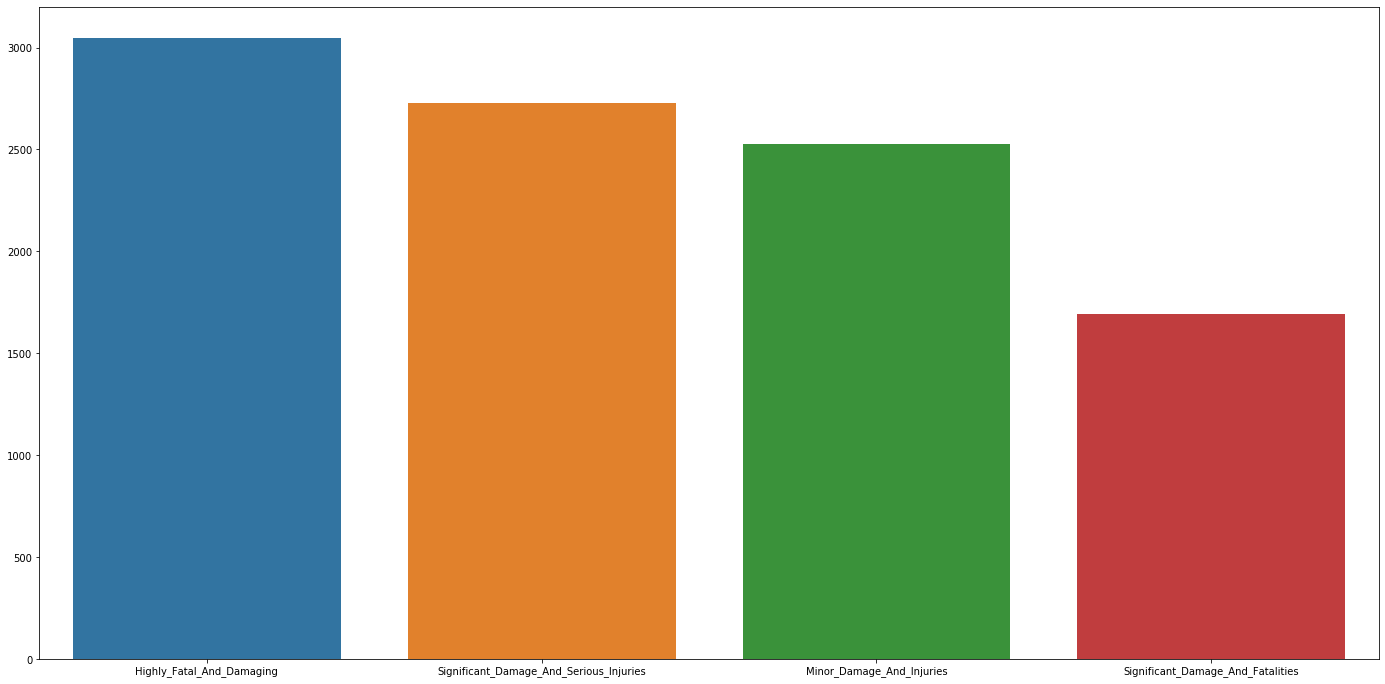

In [44]:
plt.figure(figsize=(24,12))
sns.barplot(x=target.value_counts().index,y=target.value_counts().values)

In [45]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Severity                   10000 non-null object
Safety_Score               10000 non-null float64
Days_Since_Inspection      10000 non-null int8
Total_Safety_Complaints    10000 non-null int8
Control_Metric             10000 non-null float64
Turbulence_In_gforces      10000 non-null float64
Cabin_Temperature          10000 non-null float64
Accident_Type_Code         10000 non-null int8
Max_Elevation              10000 non-null float64
Violations                 10000 non-null int8
Adverse_Weather_Metric     10000 non-null float64
Accident_ID                10000 non-null int16
dtypes: float64(6), int16(1), int8(4), object(1)
memory usage: 605.6+ KB


In [46]:
train.describe()

Safety_Score  Days_Since_Inspection  Total_Safety_Complaints  \
count     10000.000              10000.000                10000.000   
mean         41.876                 12.931                    6.564   
std          16.138                  3.540                    6.972   
min           0.000                  1.000                    0.000   
25%          30.594                 11.000                    2.000   
50%          41.279                 13.000                    4.000   
75%          52.511                 15.000                    9.000   
max         100.000                 23.000                   54.000   

       Control_Metric  Turbulence_In_gforces  Cabin_Temperature  \
count       10000.000              10000.000          10000.000   
mean           65.145                  0.381             79.969   
std            11.883                  0.121              2.760   
min             0.000                  0.134             74.740   
25%            56.928                  0.294             77.960   
50%            65.588                  0.366             79.540   
75%            73.336                  0.451             81.560   
max           100.000                  0.883             97.510   

       Accident_Type_Code  Max_Elevation  Violations  Adverse_Weather_Metric  \
count           10000.000      10000.000   10000.000               1.000e+04   
mean                3.815      32001.803       2.012               2.556e-01   
std                 1.903       9431.995       1.040               3.811e-01   
min                 1.000        831.696       0.000               3.164e-04   
25%                 2.000      25757.637       1.000               1.206e-02   
50%                 4.000      32060.336       2.000               7.447e-02   
75%                 5.000      38380.642       3.000               3.541e-01   
max                 7.000      64297.651       5.000               2.365e+00   

       Accident_ID  
count    10000.000  
mean      6266.554  
std       3610.170  
min          2.000  
25%       3139.750  
50%       6280.500  
75%       9391.500  
max      12500.000

In [47]:
train.describe()

Safety_Score  Days_Since_Inspection  Total_Safety_Complaints  \
count     10000.000              10000.000                10000.000   
mean         41.876                 12.931                    6.564   
std          16.138                  3.540                    6.972   
min           0.000                  1.000                    0.000   
25%          30.594                 11.000                    2.000   
50%          41.279                 13.000                    4.000   
75%          52.511                 15.000                    9.000   
max         100.000                 23.000                   54.000   

       Control_Metric  Turbulence_In_gforces  Cabin_Temperature  \
count       10000.000              10000.000          10000.000   
mean           65.145                  0.381             79.969   
std            11.883                  0.121              2.760   
min             0.000                  0.134             74.740   
25%            56.928                  0.294             77.960   
50%            65.588                  0.366             79.540   
75%            73.336                  0.451             81.560   
max           100.000                  0.883             97.510   

       Accident_Type_Code  Max_Elevation  Violations  Adverse_Weather_Metric  \
count           10000.000      10000.000   10000.000               1.000e+04   
mean                3.815      32001.803       2.012               2.556e-01   
std                 1.903       9431.995       1.040               3.811e-01   
min                 1.000        831.696       0.000               3.164e-04   
25%                 2.000      25757.637       1.000               1.206e-02   
50%                 4.000      32060.336       2.000               7.447e-02   
75%                 5.000      38380.642       3.000               3.541e-01   
max                 7.000      64297.651       5.000               2.365e+00   

       Accident_ID  
count    10000.000  
mean      6266.554  
std       3610.170  
min          2.000  
25%       3139.750  
50%       6280.500  
75%       9391.500  
max      12500.000

In [48]:
train.columns

Index(['Severity', 'Safety_Score', 'Days_Since_Inspection',
       'Total_Safety_Complaints', 'Control_Metric', 'Turbulence_In_gforces',
       'Cabin_Temperature', 'Accident_Type_Code', 'Max_Elevation',
       'Violations', 'Adverse_Weather_Metric', 'Accident_ID'],
      dtype='object')

In [49]:
train.nunique()

Severity                       4
Safety_Score                1175
Days_Since_Inspection         23
Total_Safety_Complaints       44
Control_Metric               952
Turbulence_In_gforces       1117
Cabin_Temperature            950
Accident_Type_Code             7
Max_Elevation               4191
Violations                     6
Adverse_Weather_Metric      4258
Accident_ID                10000
dtype: int64

In [50]:
test.nunique()

Safety_Score                910
Days_Since_Inspection        23
Total_Safety_Complaints      42
Control_Metric              772
Turbulence_In_gforces       873
Cabin_Temperature           764
Accident_Type_Code            7
Max_Elevation              1922
Violations                    6
Adverse_Weather_Metric     1958
Accident_ID                2500
dtype: int64

In [51]:
train.isna().sum()

Severity                   0
Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64

In [52]:
test.isna().sum()

Safety_Score               0
Days_Since_Inspection      0
Total_Safety_Complaints    0
Control_Metric             0
Turbulence_In_gforces      0
Cabin_Temperature          0
Accident_Type_Code         0
Max_Elevation              0
Violations                 0
Adverse_Weather_Metric     0
Accident_ID                0
dtype: int64

## EDA

In [53]:
test[param['target']] = train[param['target']].iloc[0]

In [54]:
encs = preprocess(0)

Adding...
Subtracting...


0.000367501300988579

Dividing...


1.3951242613157113

Multiplying...



Logging...



Exponential...
Polynomial Features...
Encoding...



Frequency Encoding...


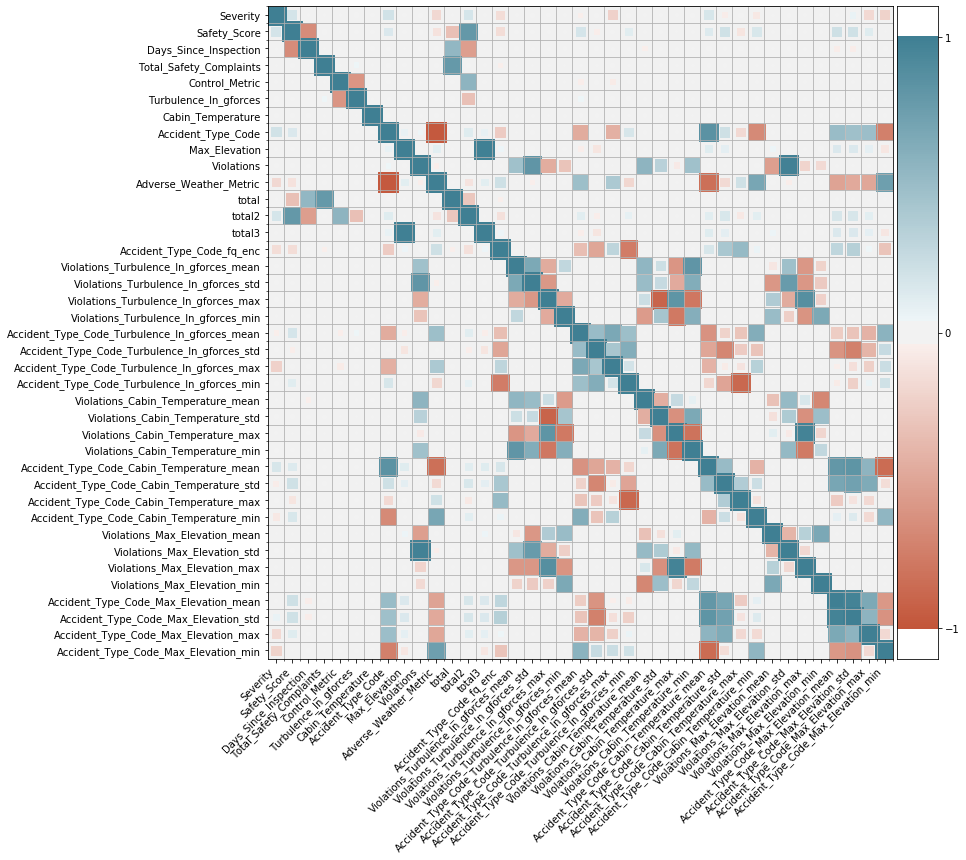

In [55]:
plt.figure(figsize=(12,12))
corrplot(train[[col for col in train.columns if col not in param['id_columns'][0]]].corr().replace(np.nan, param['fill_na']['with'][0]), size_scale=400)

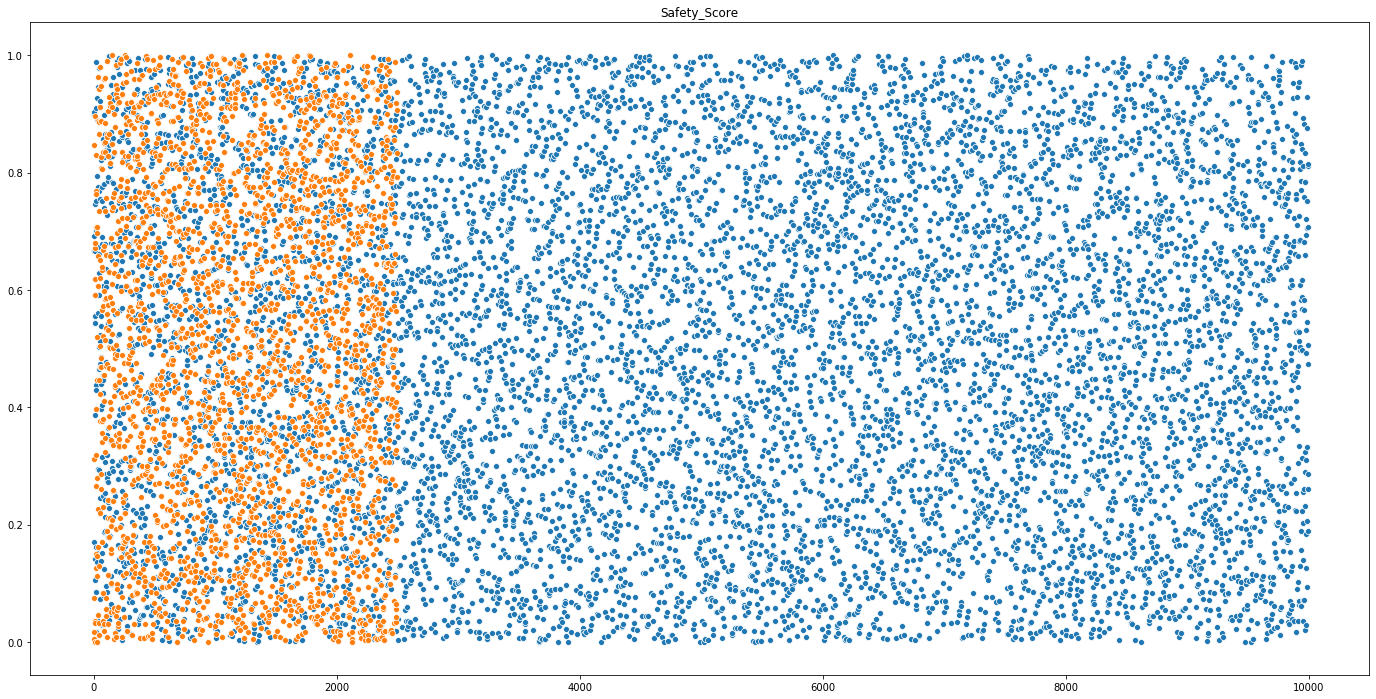

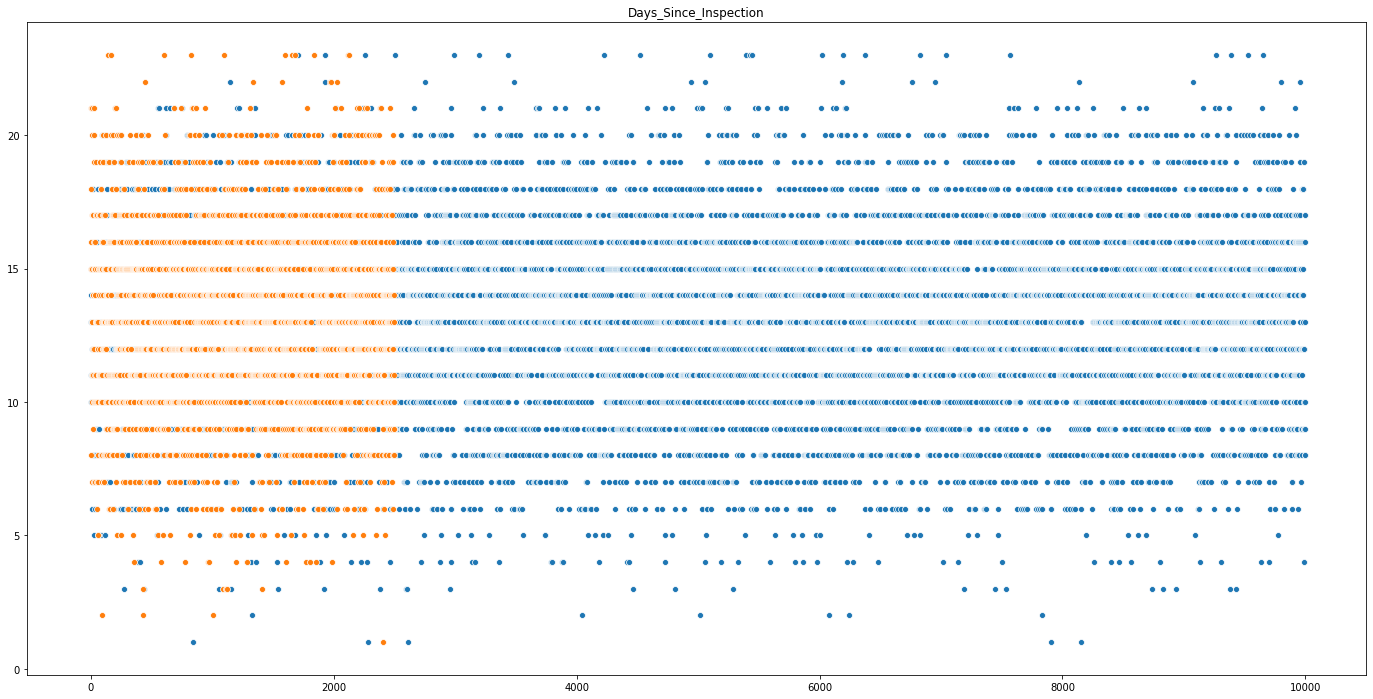

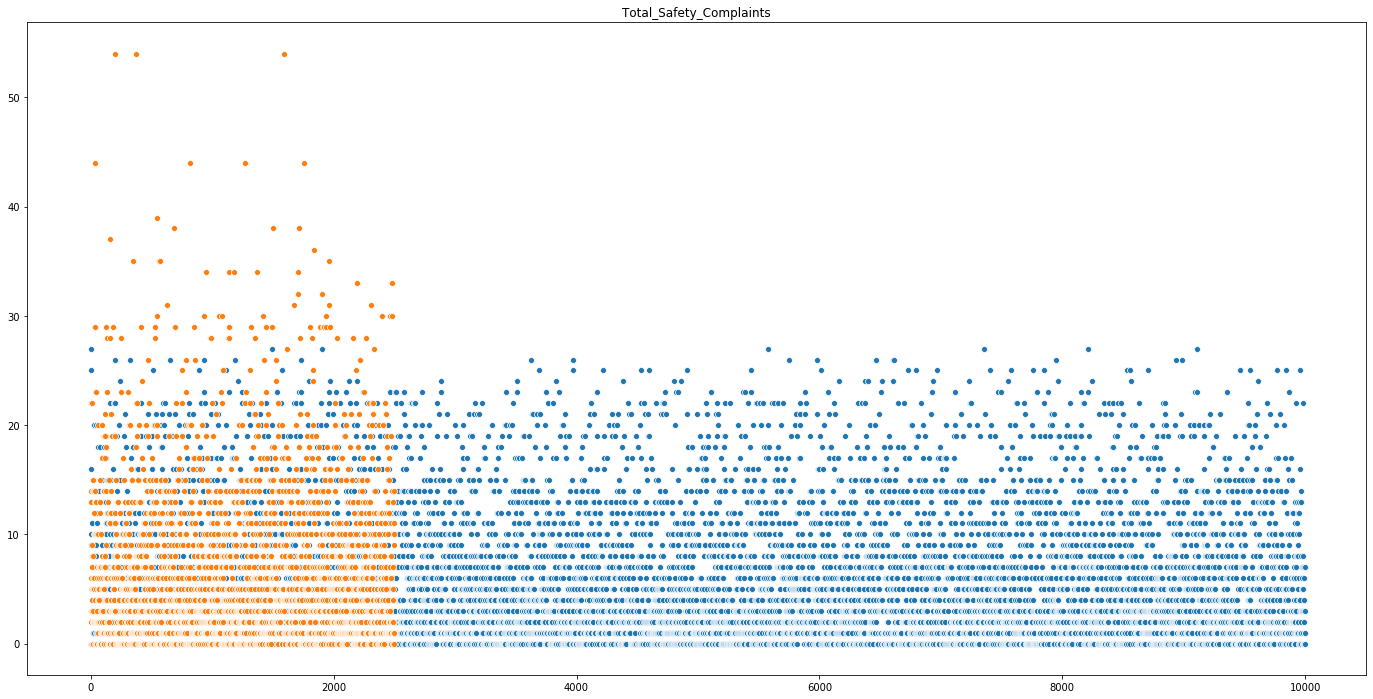

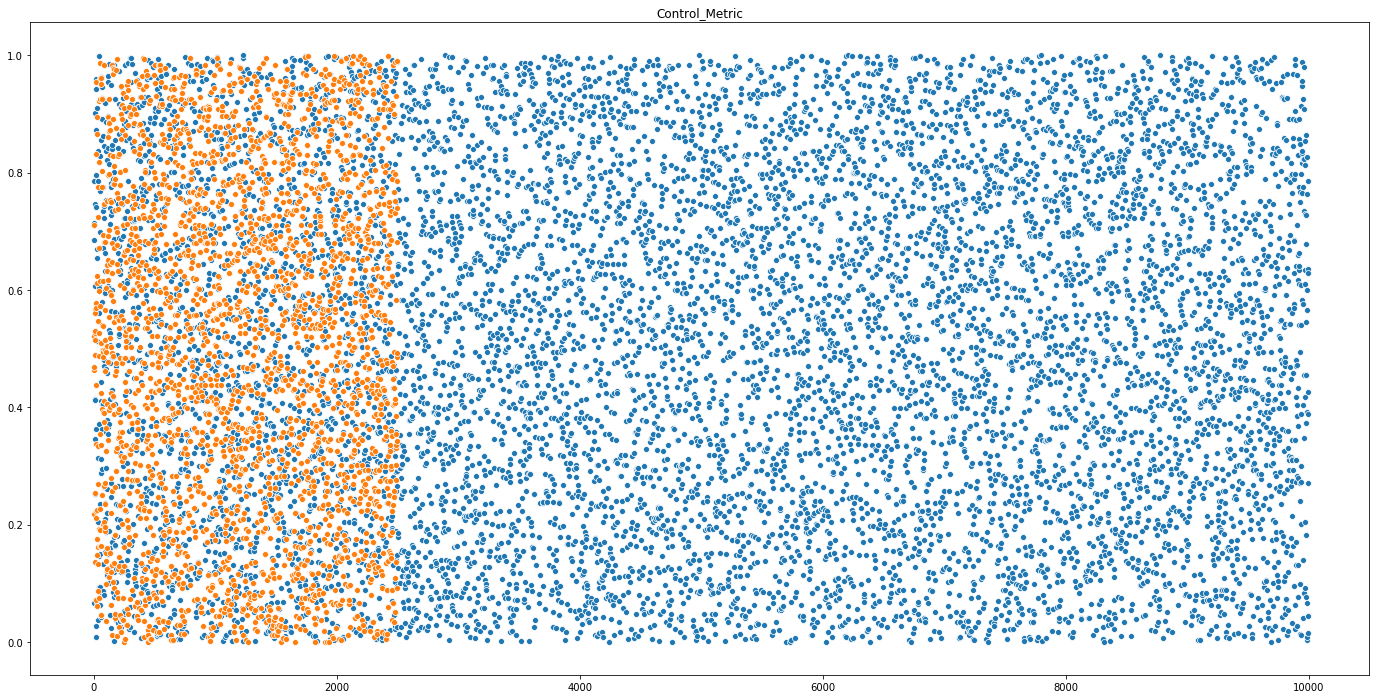

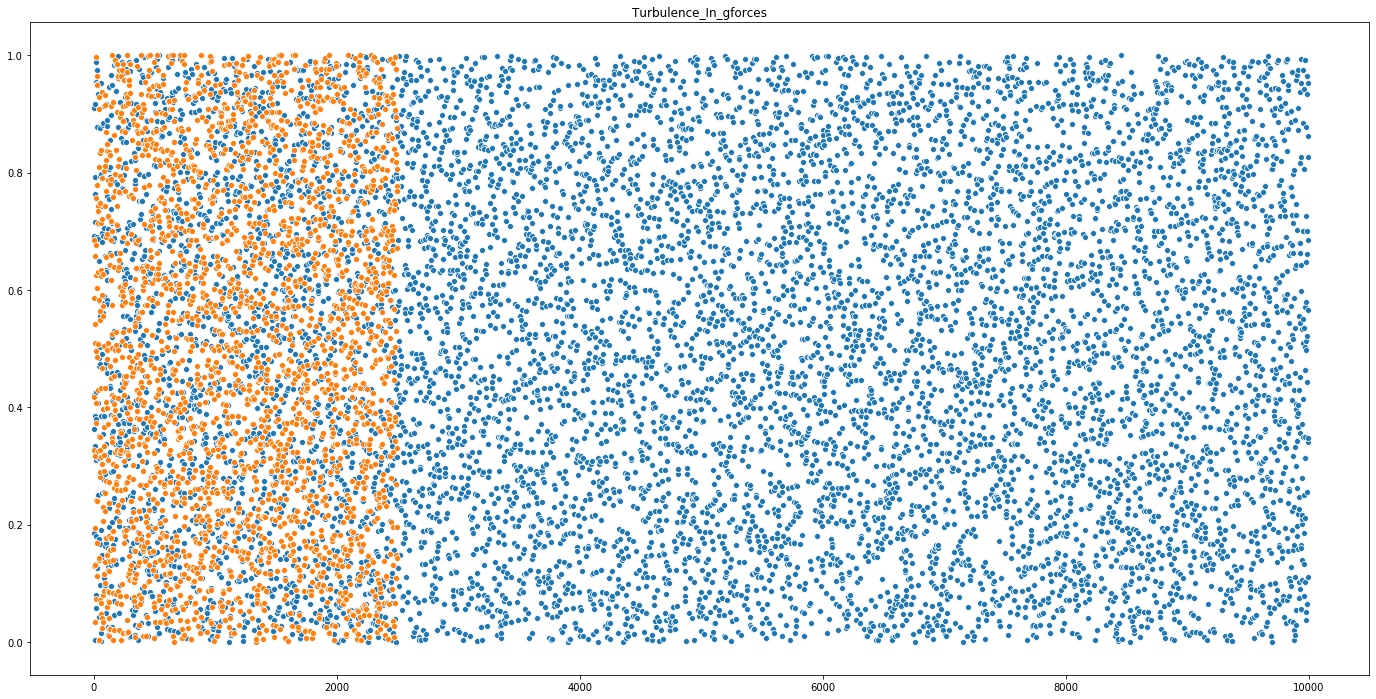

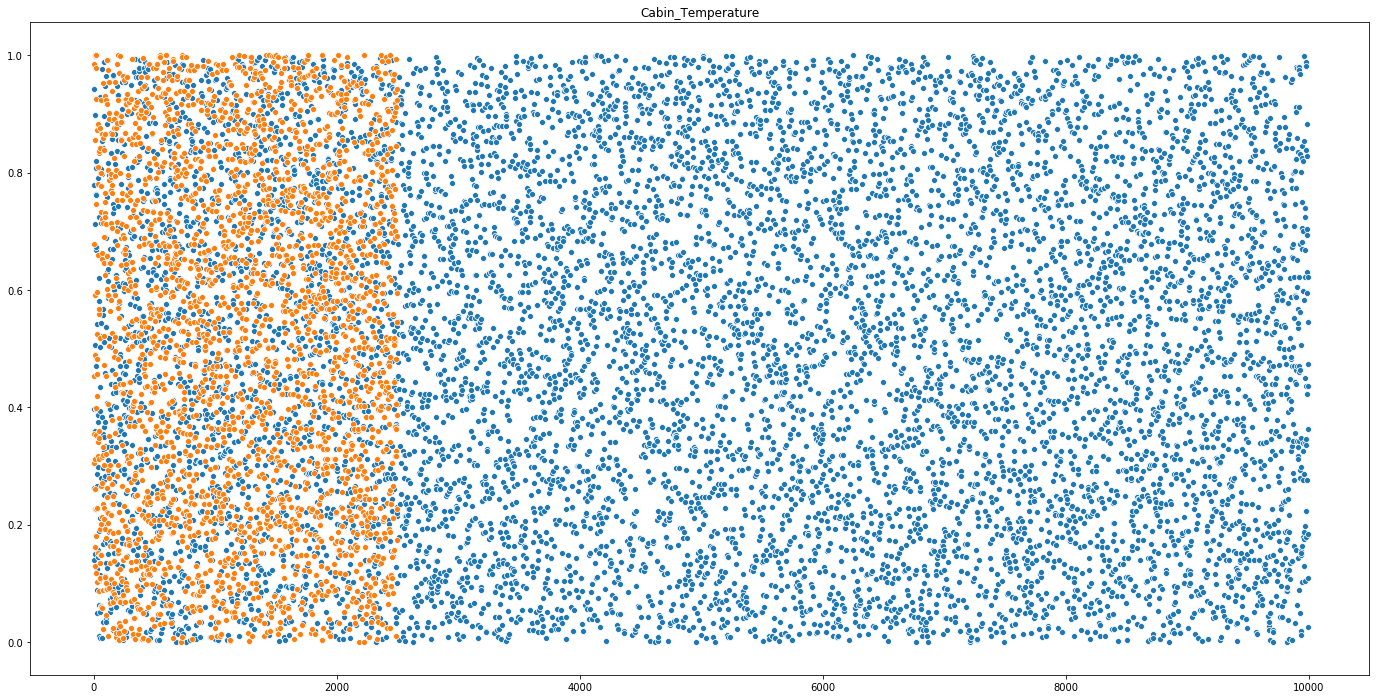

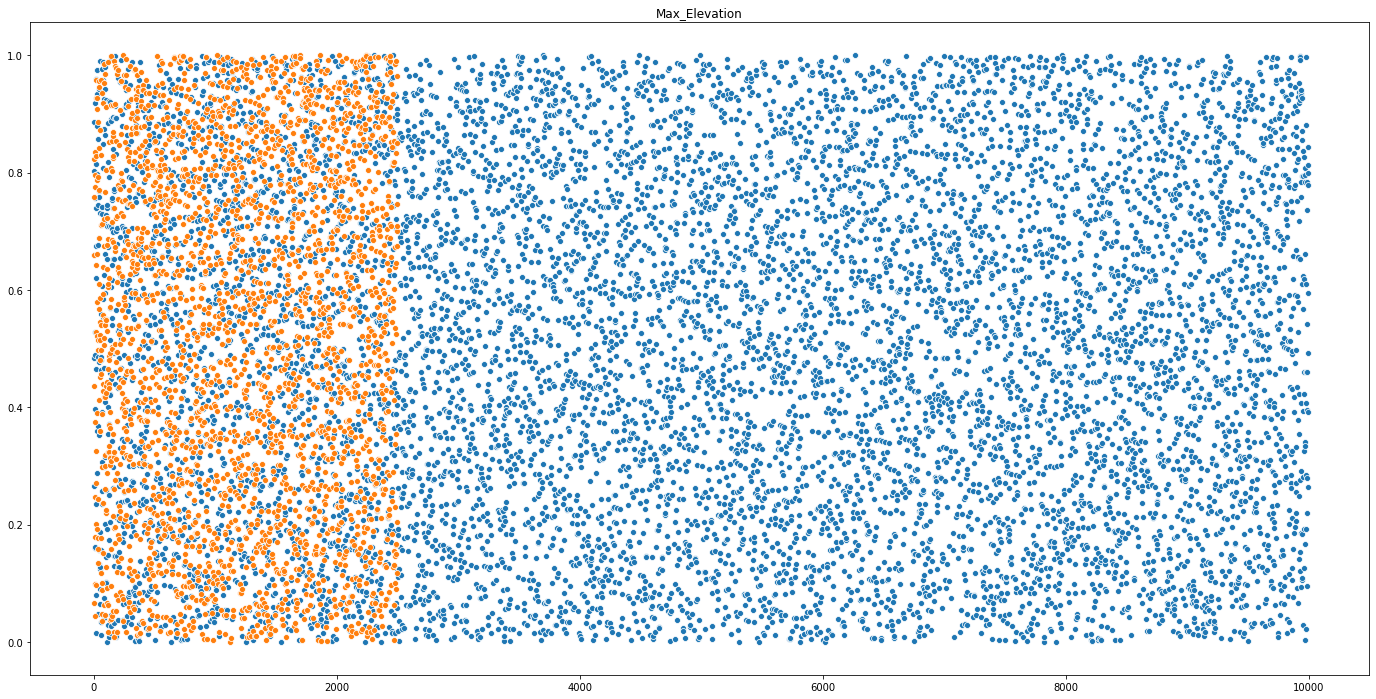

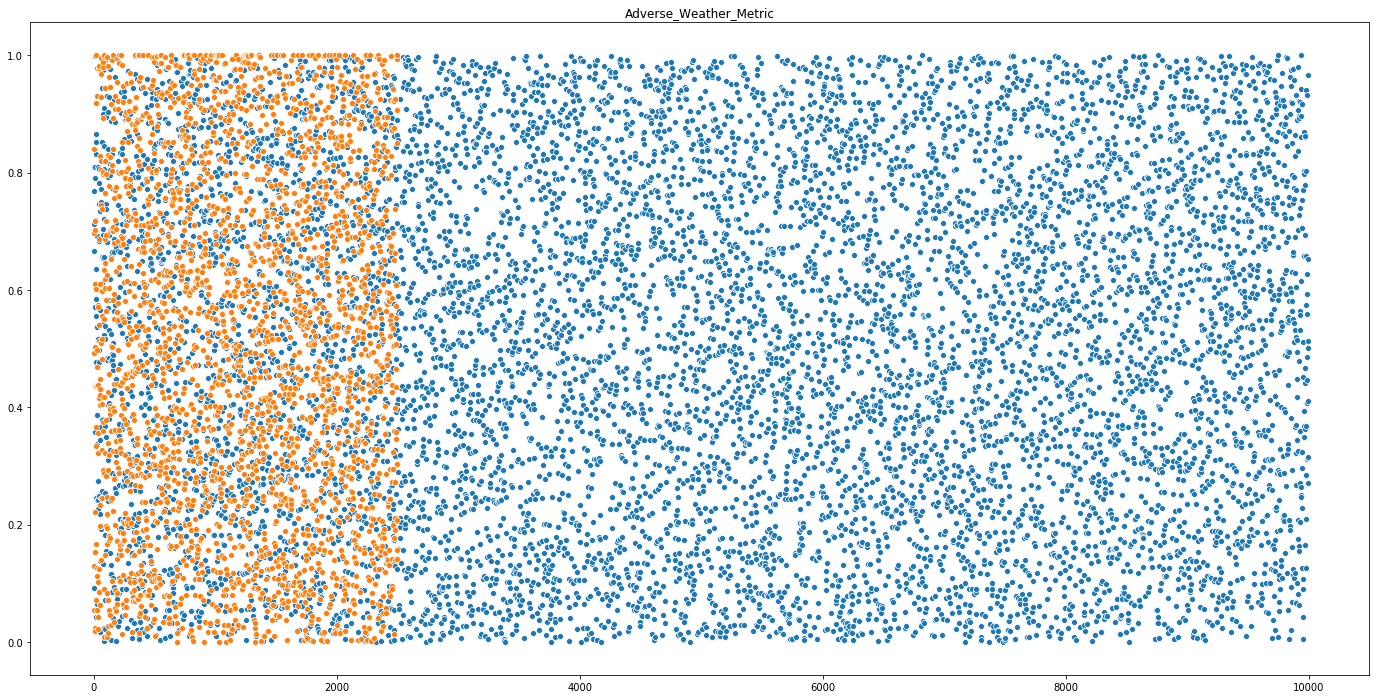

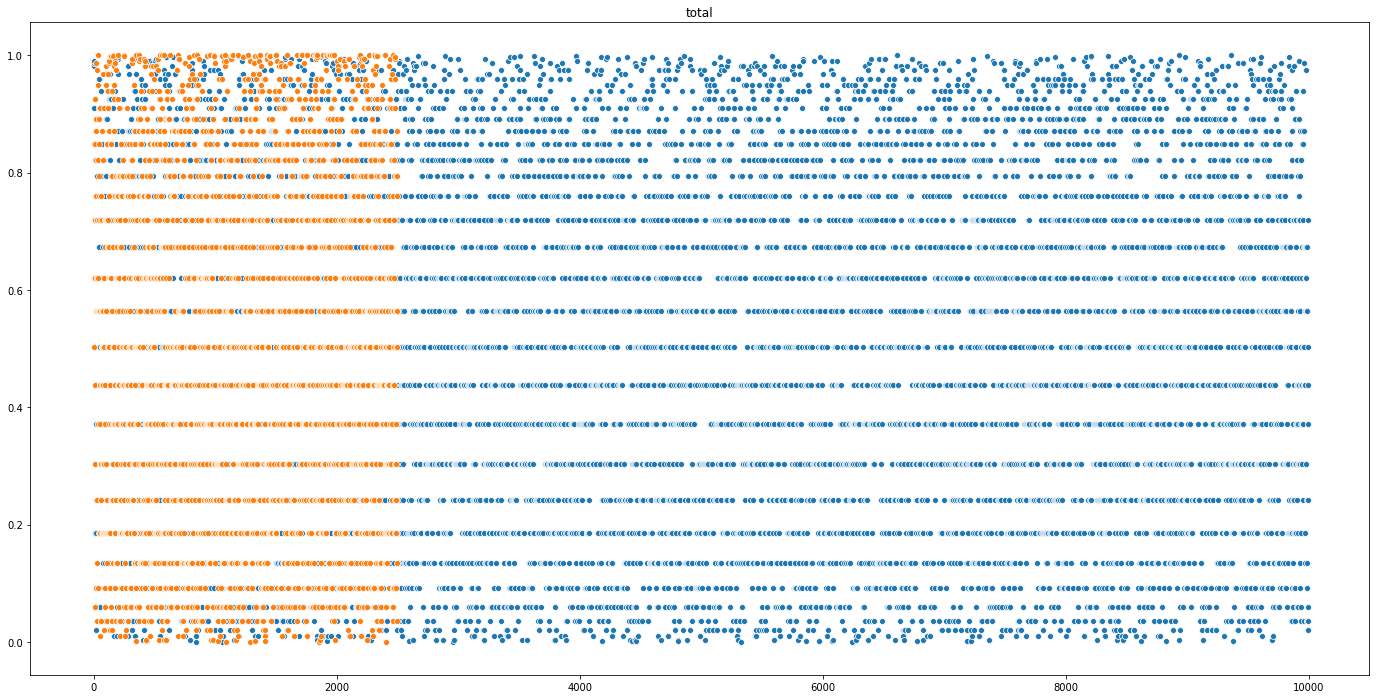

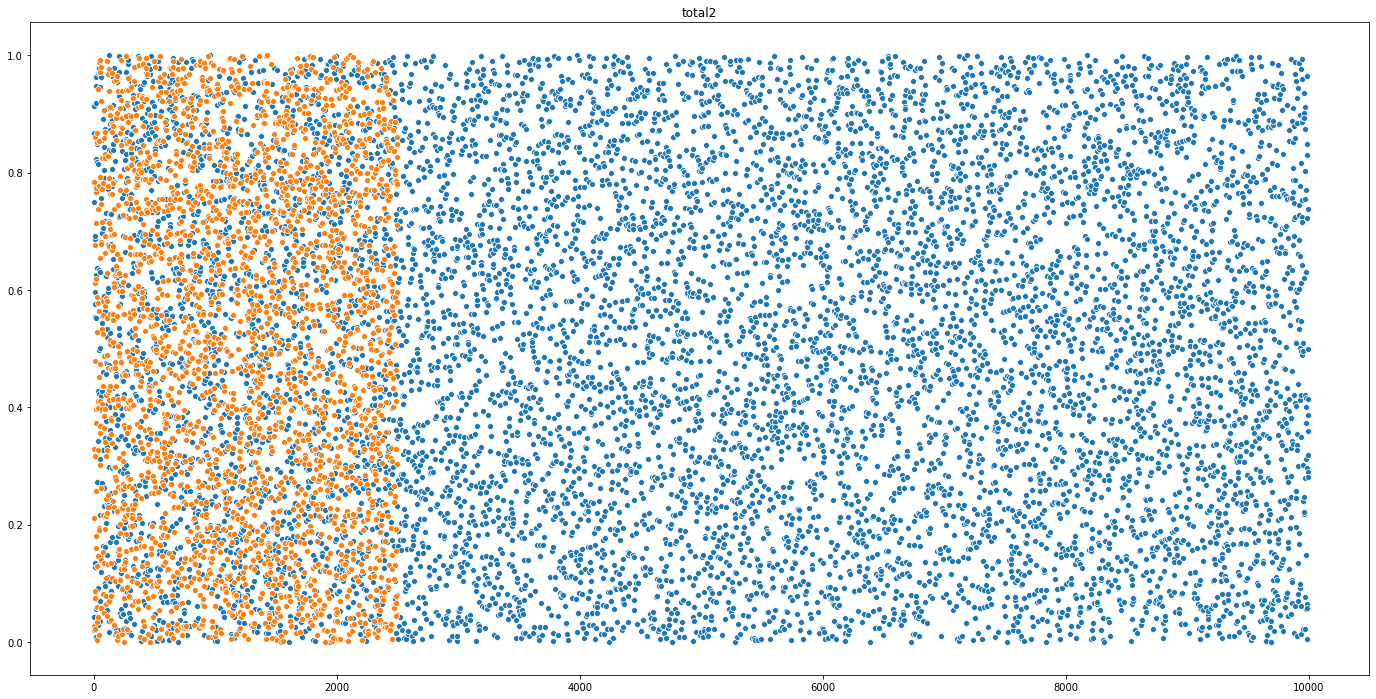

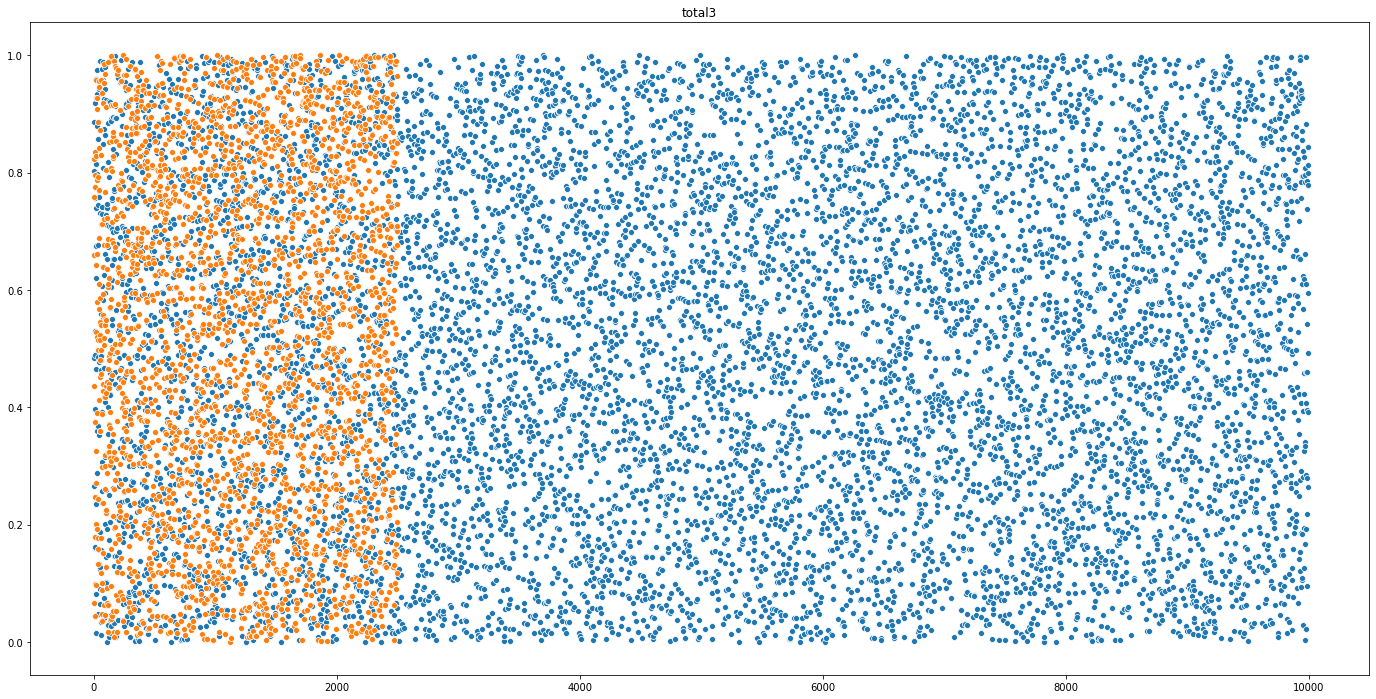

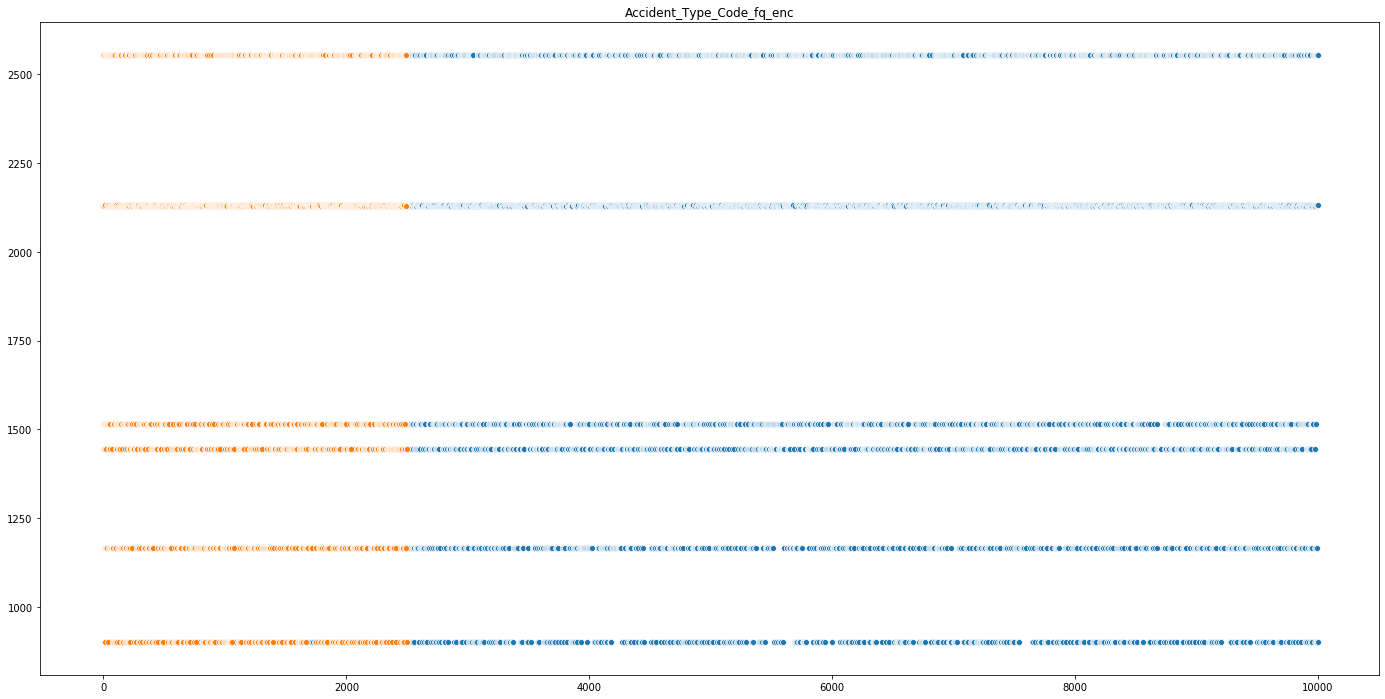

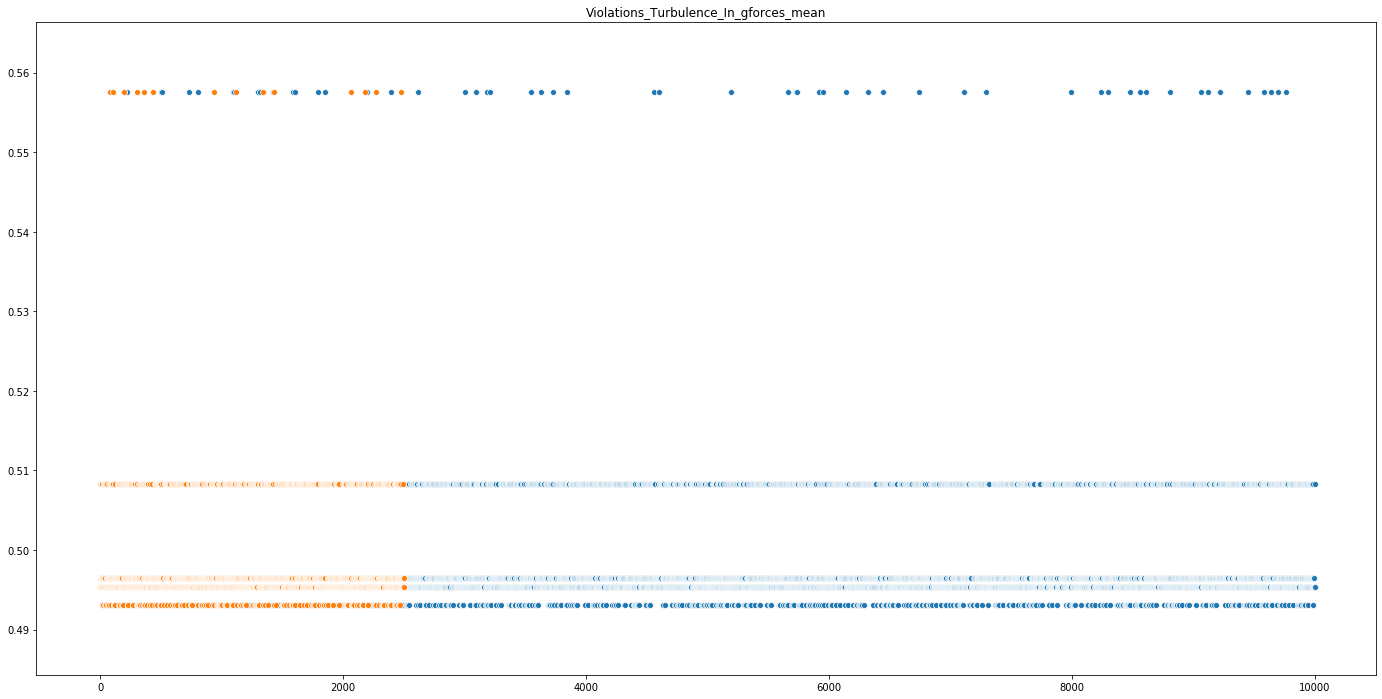

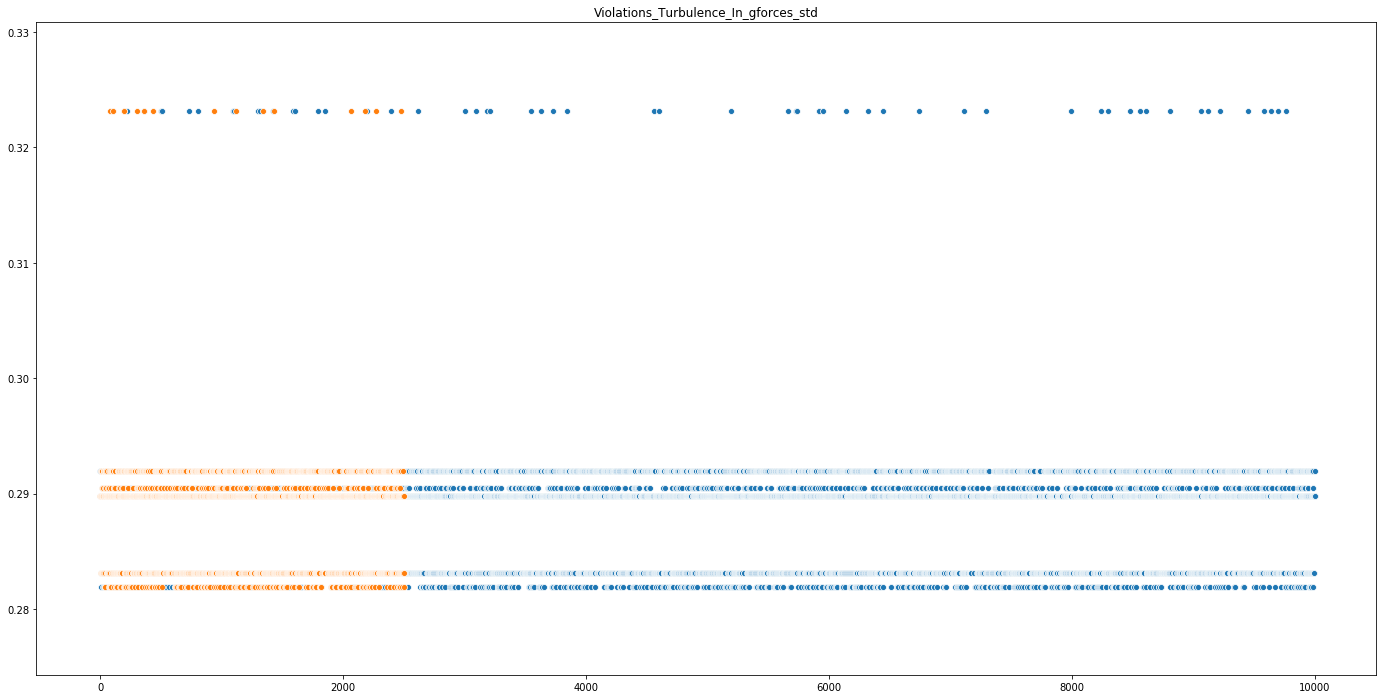

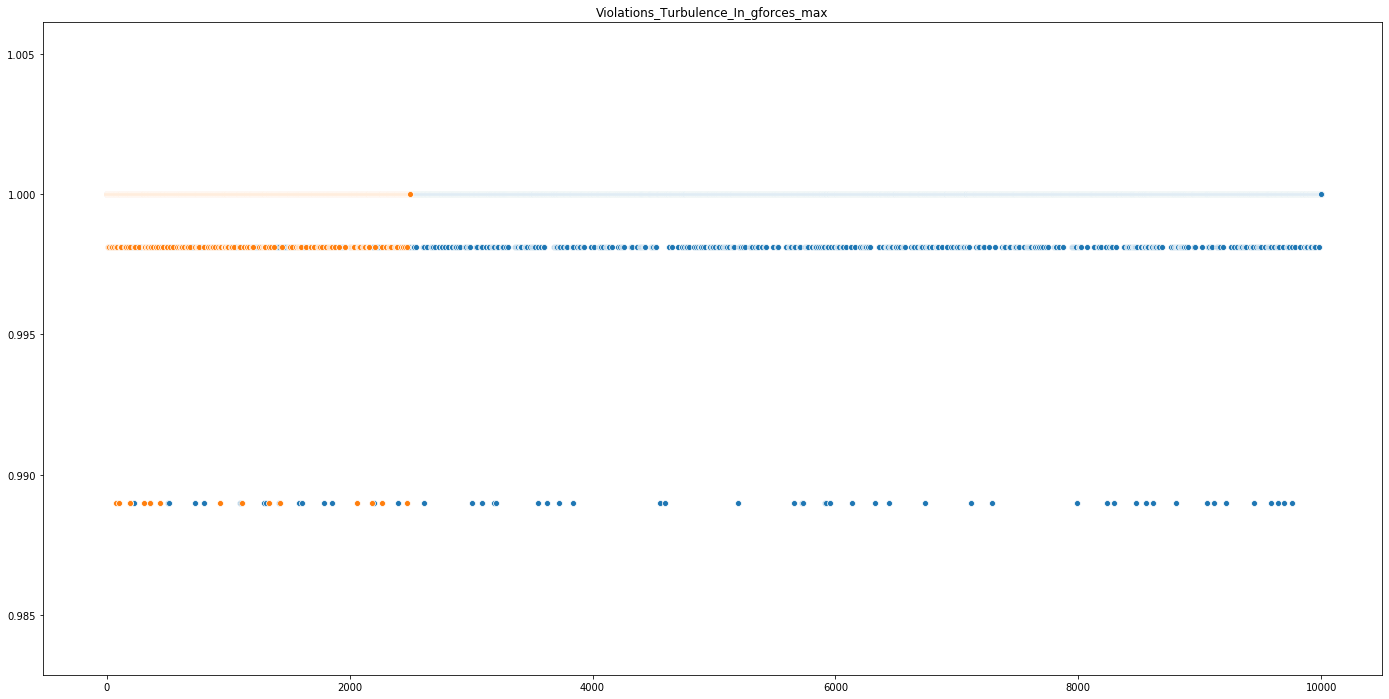

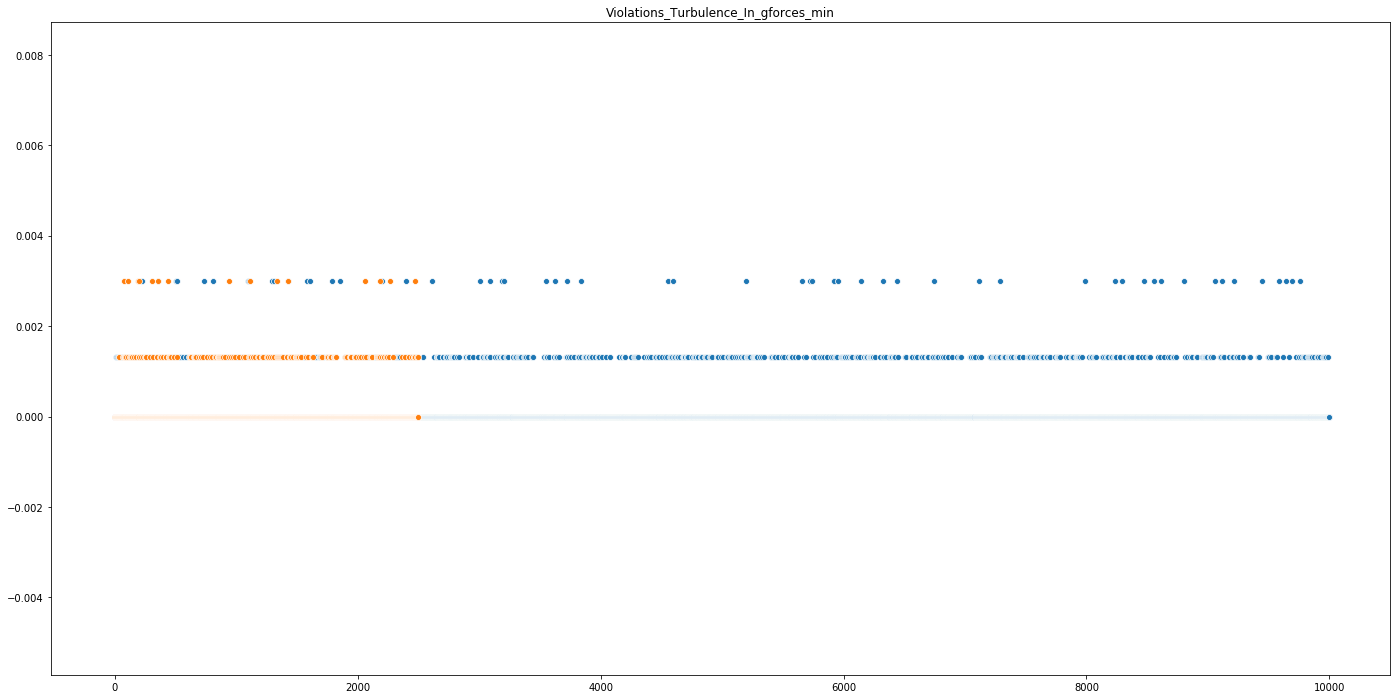

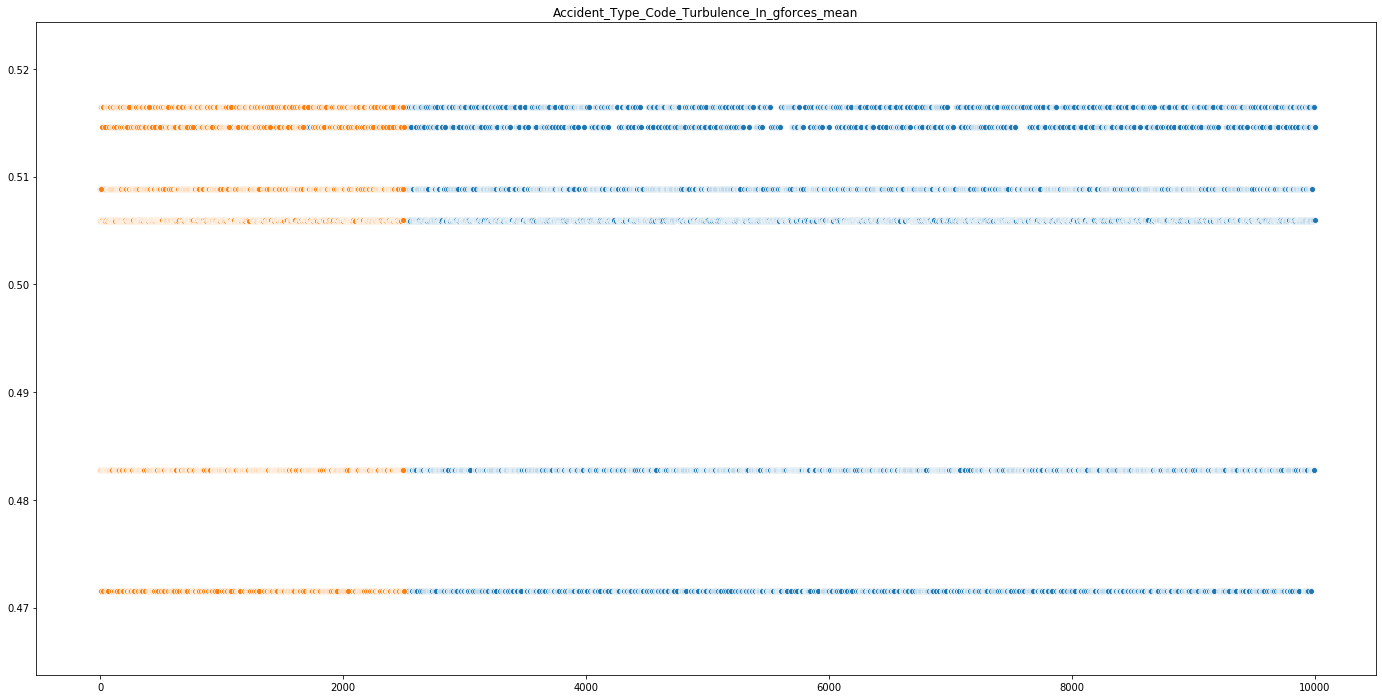

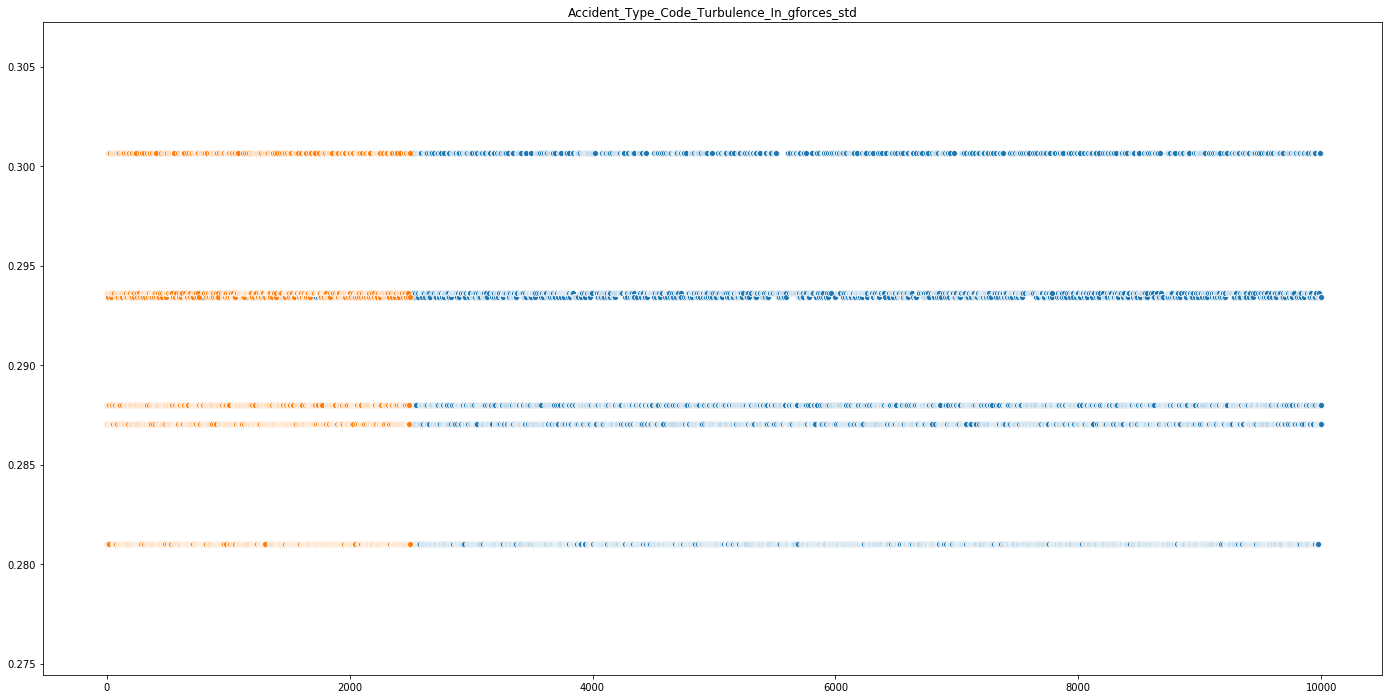

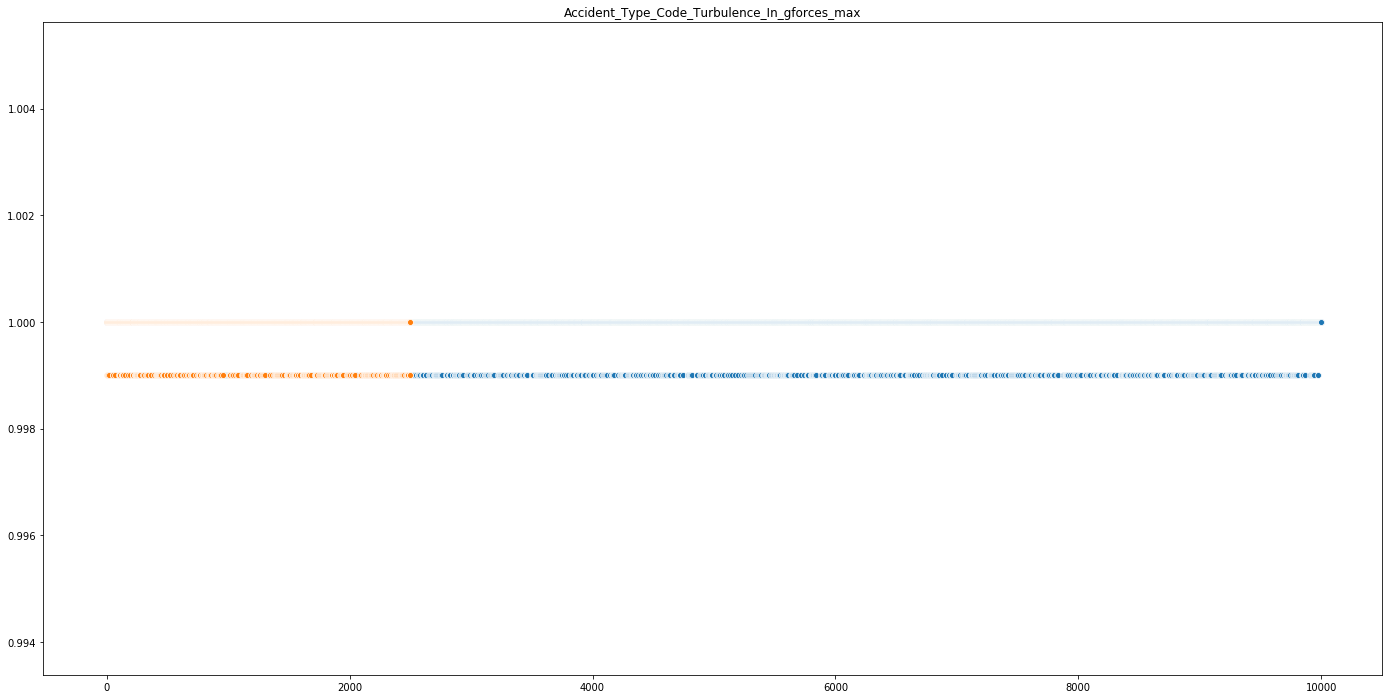

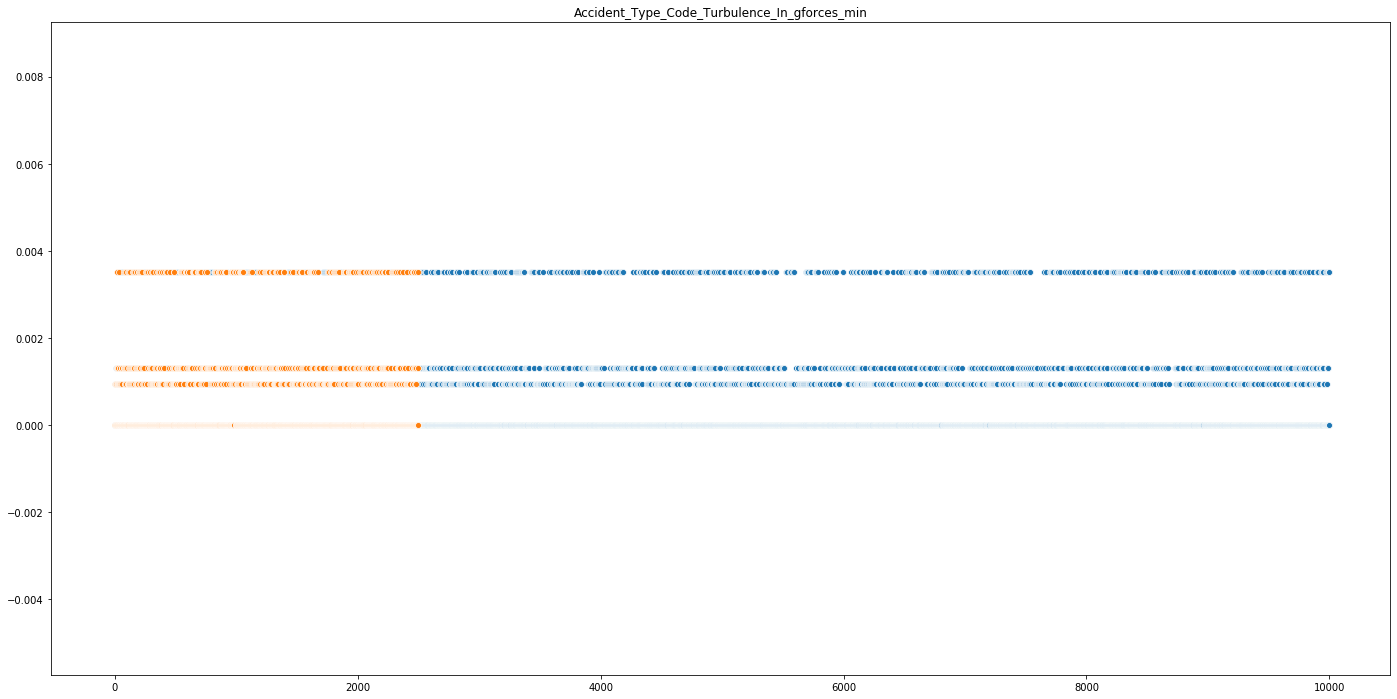

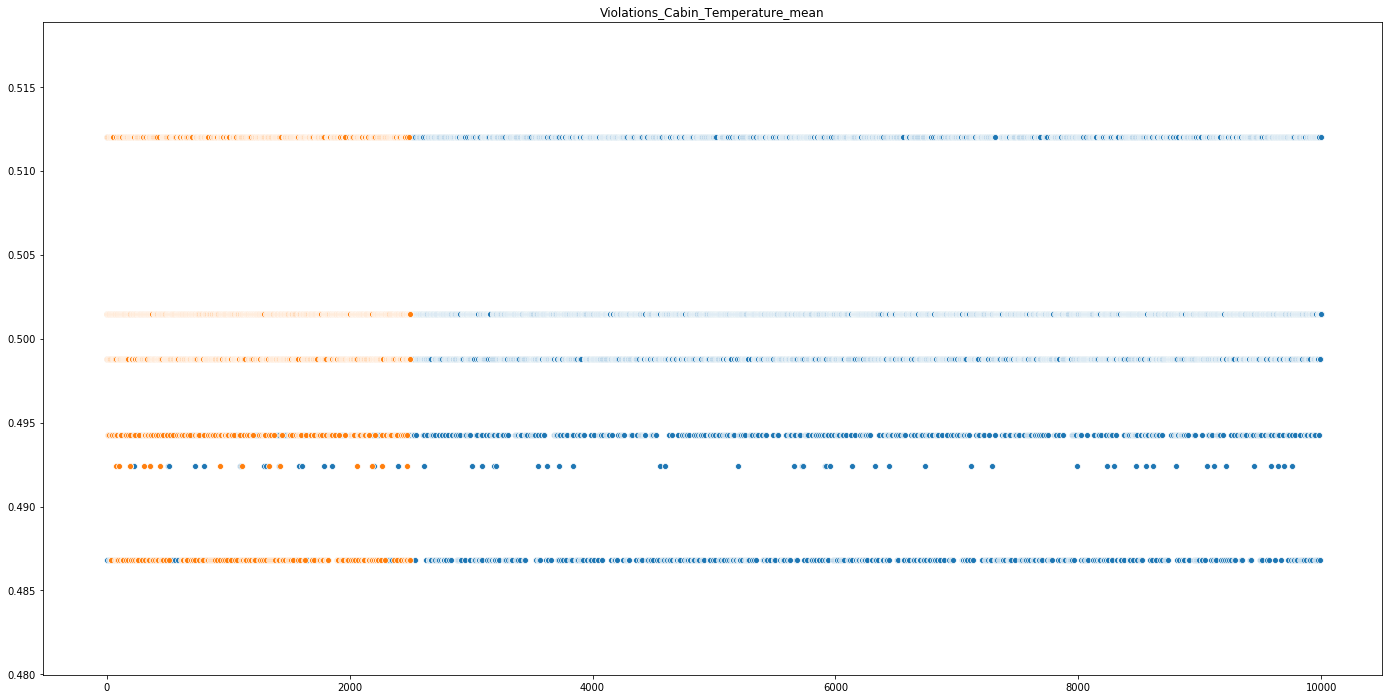

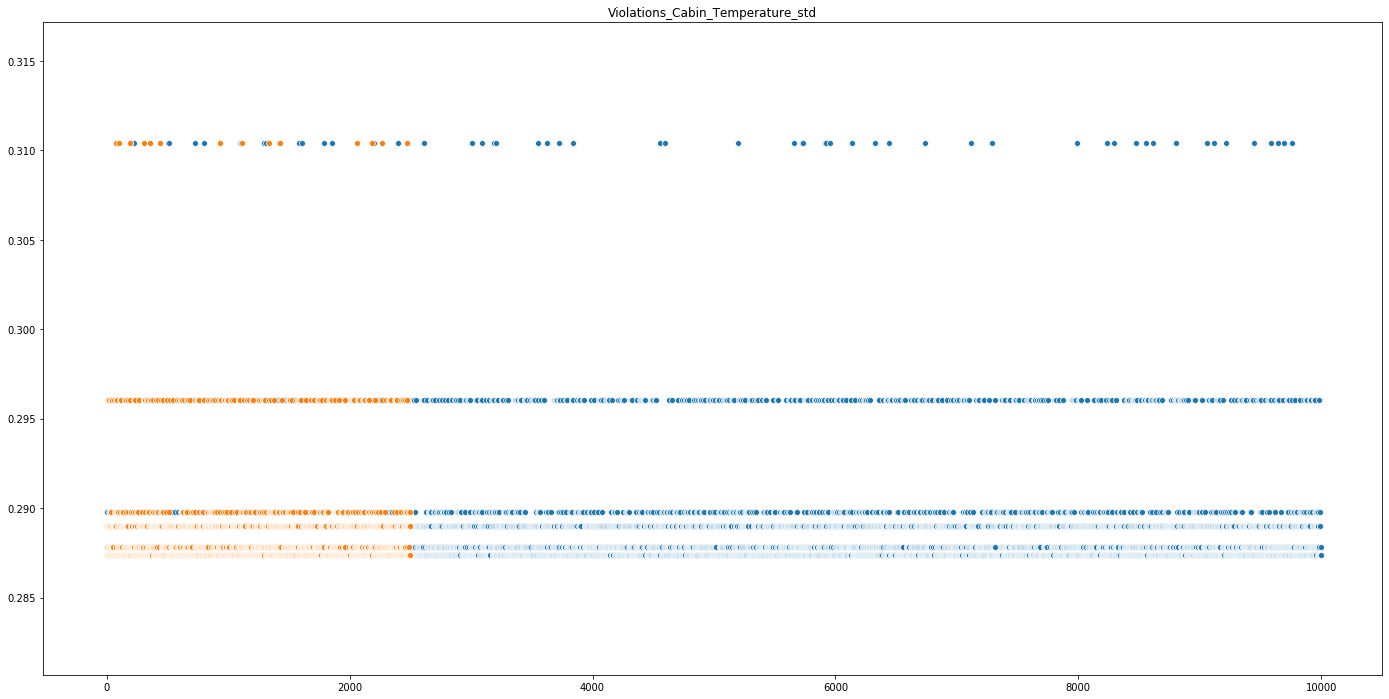

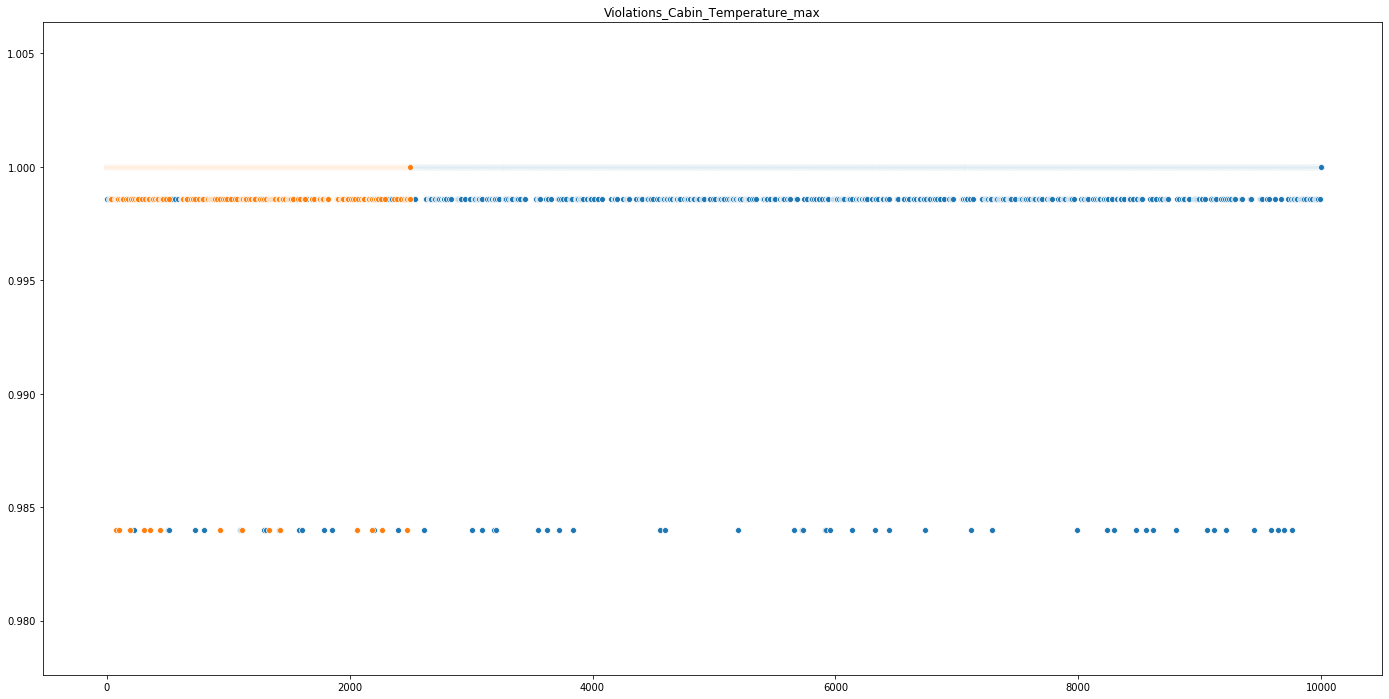

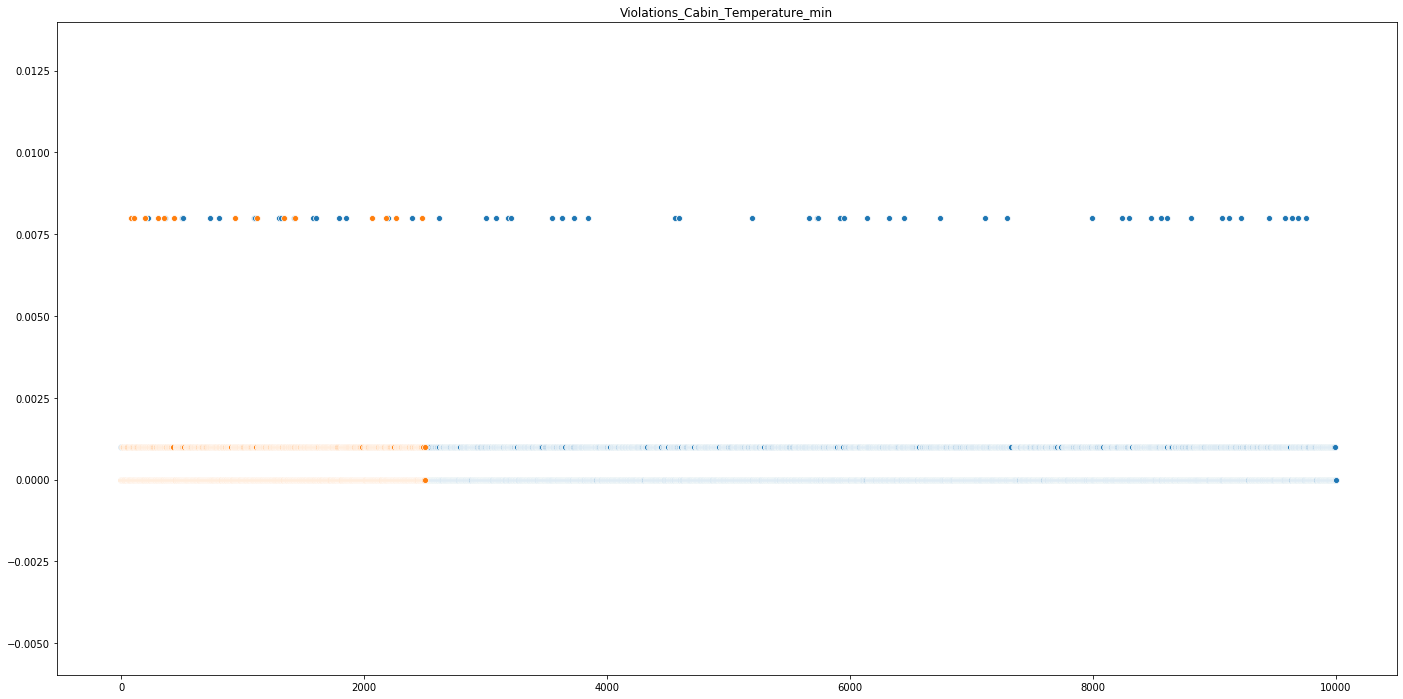

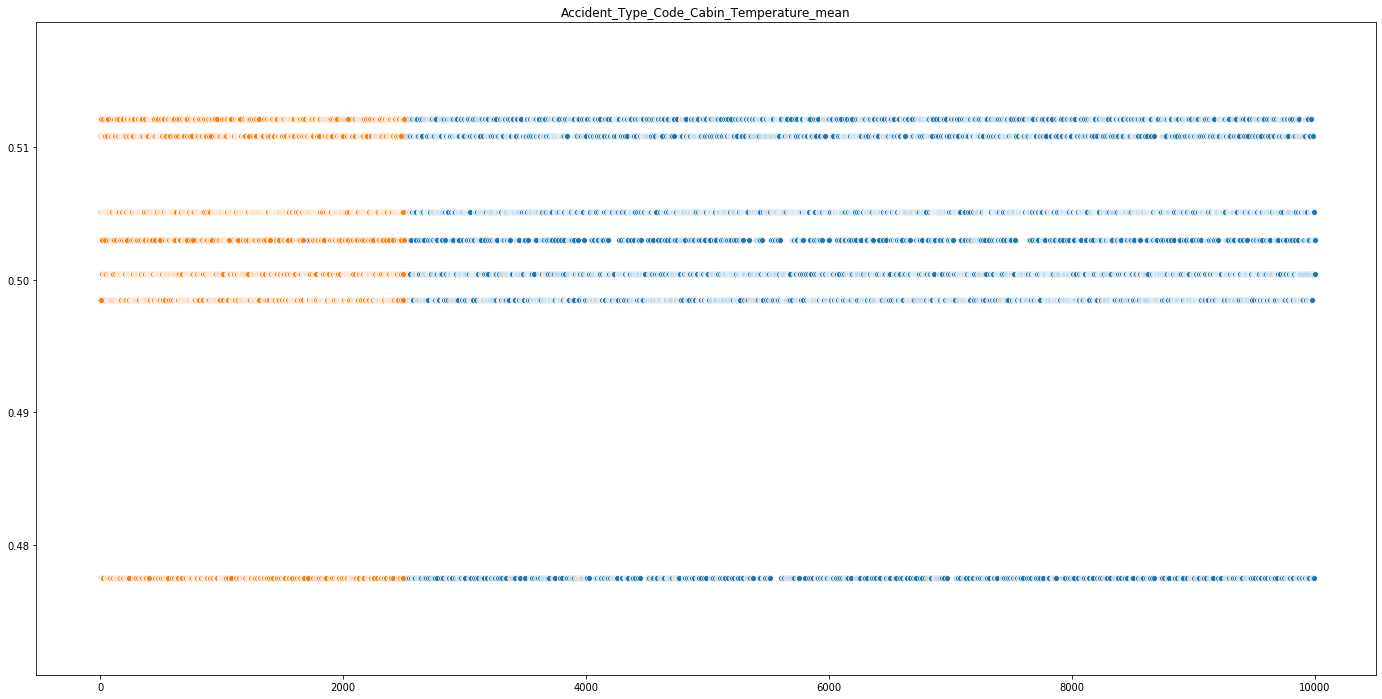

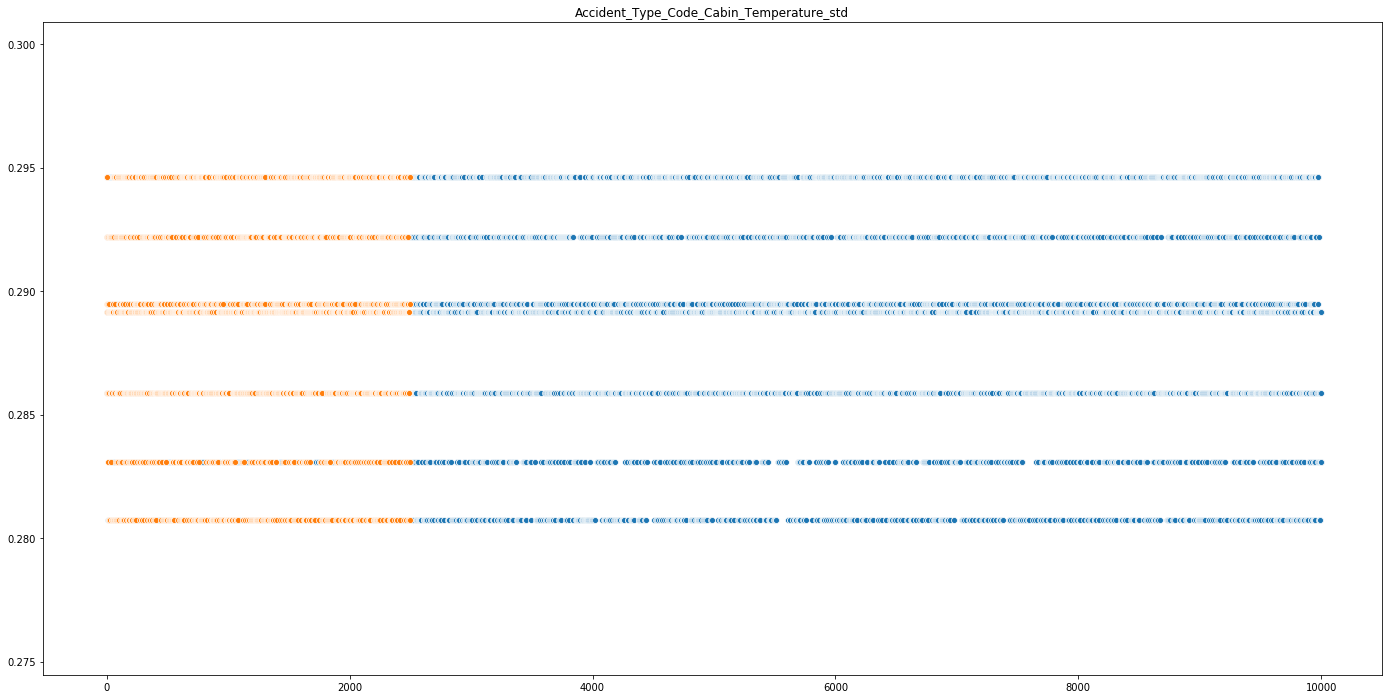

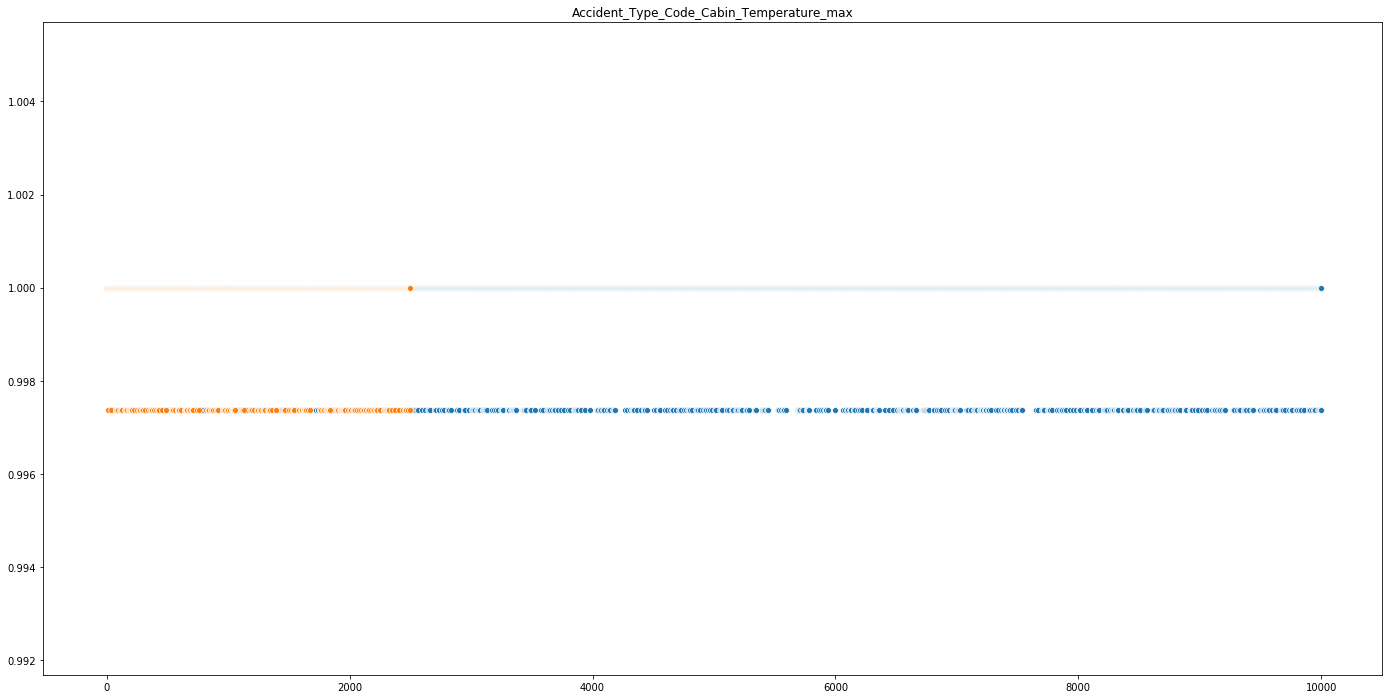

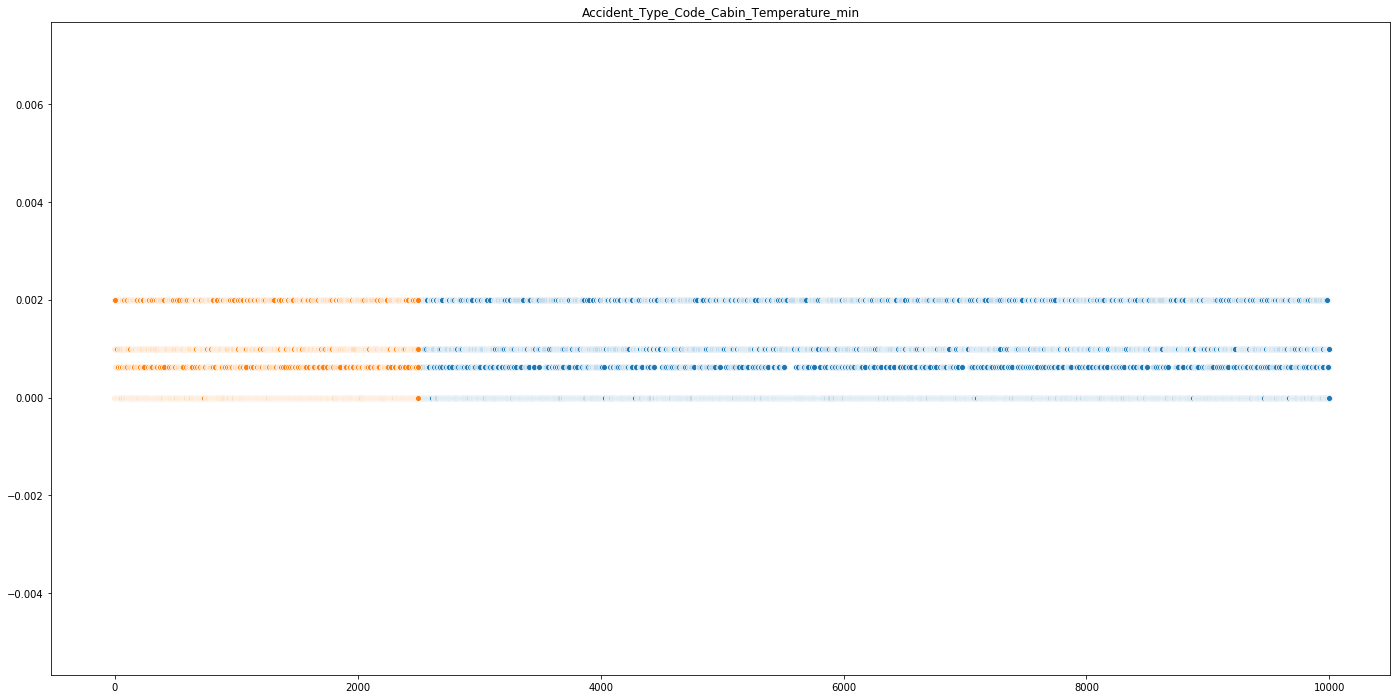

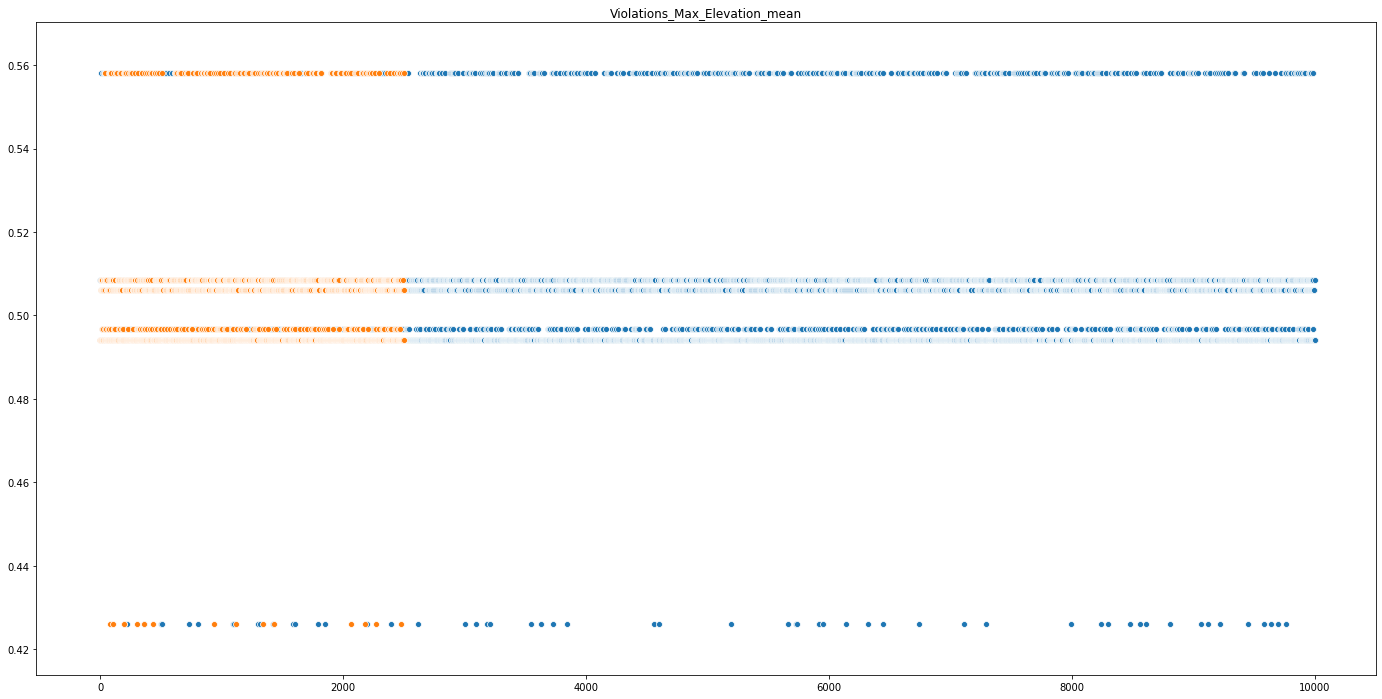

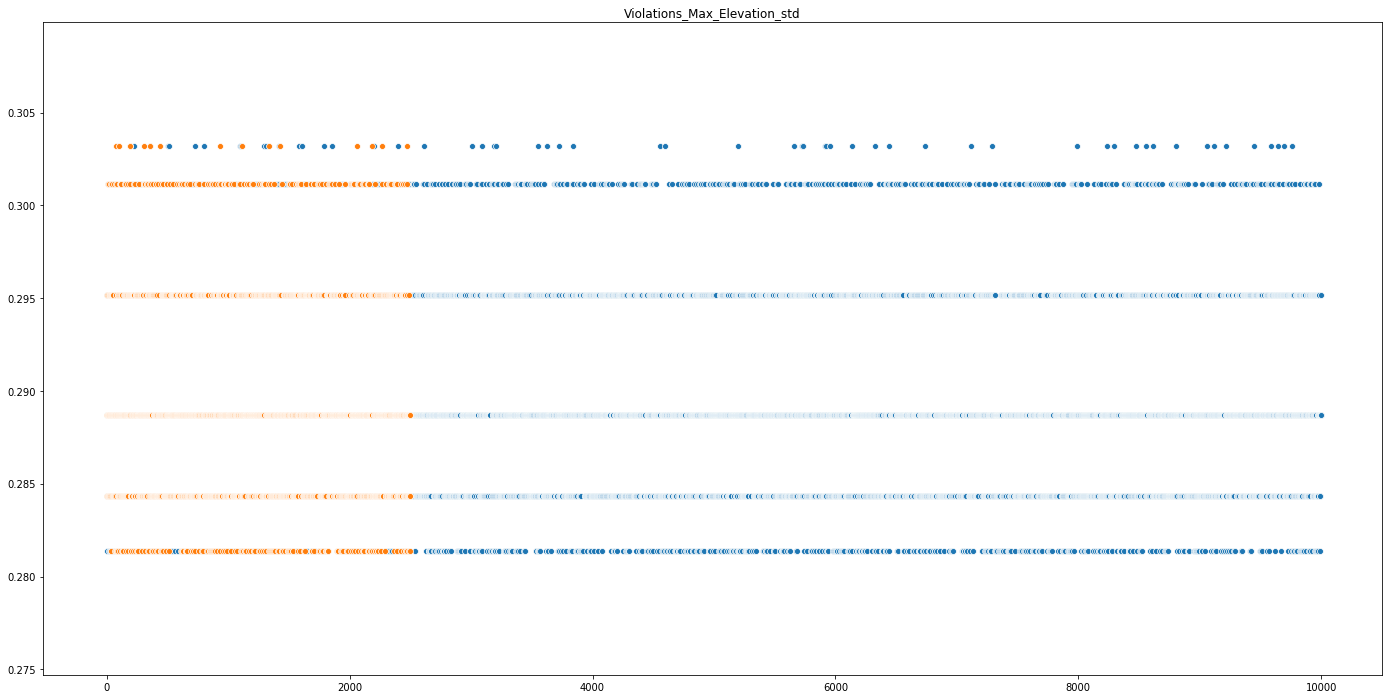

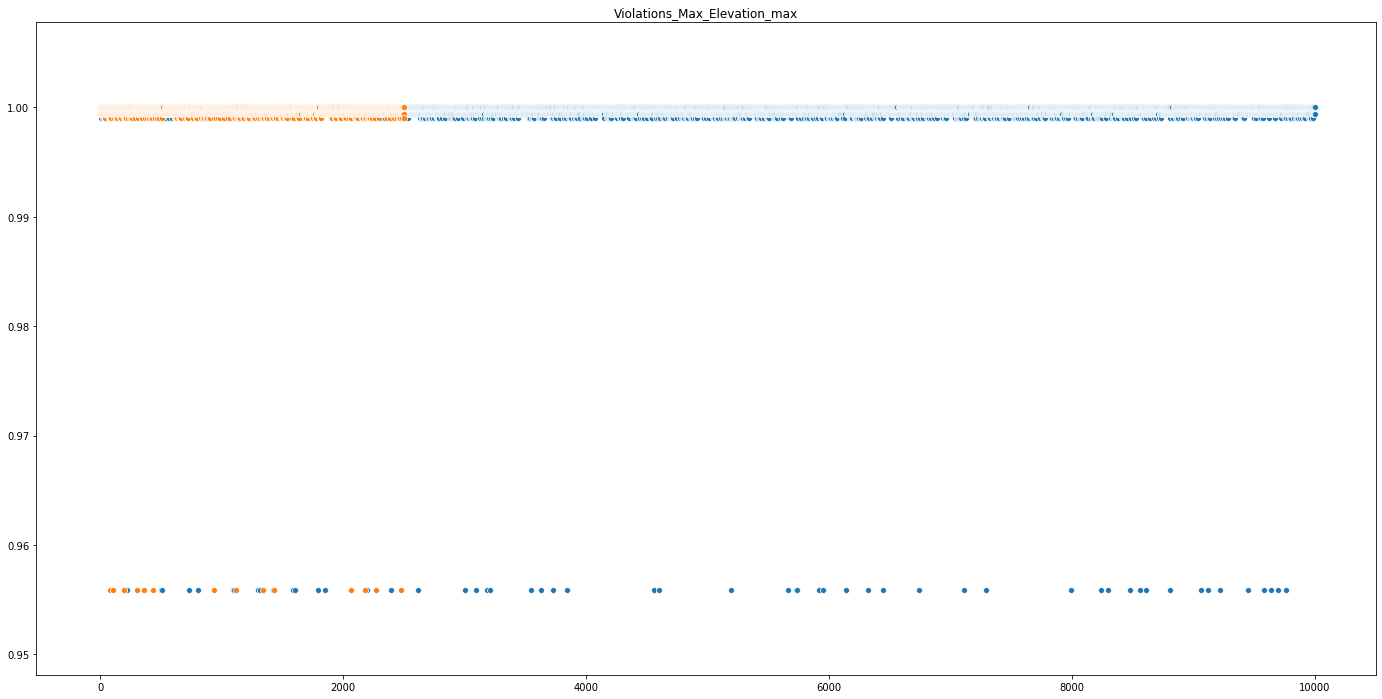

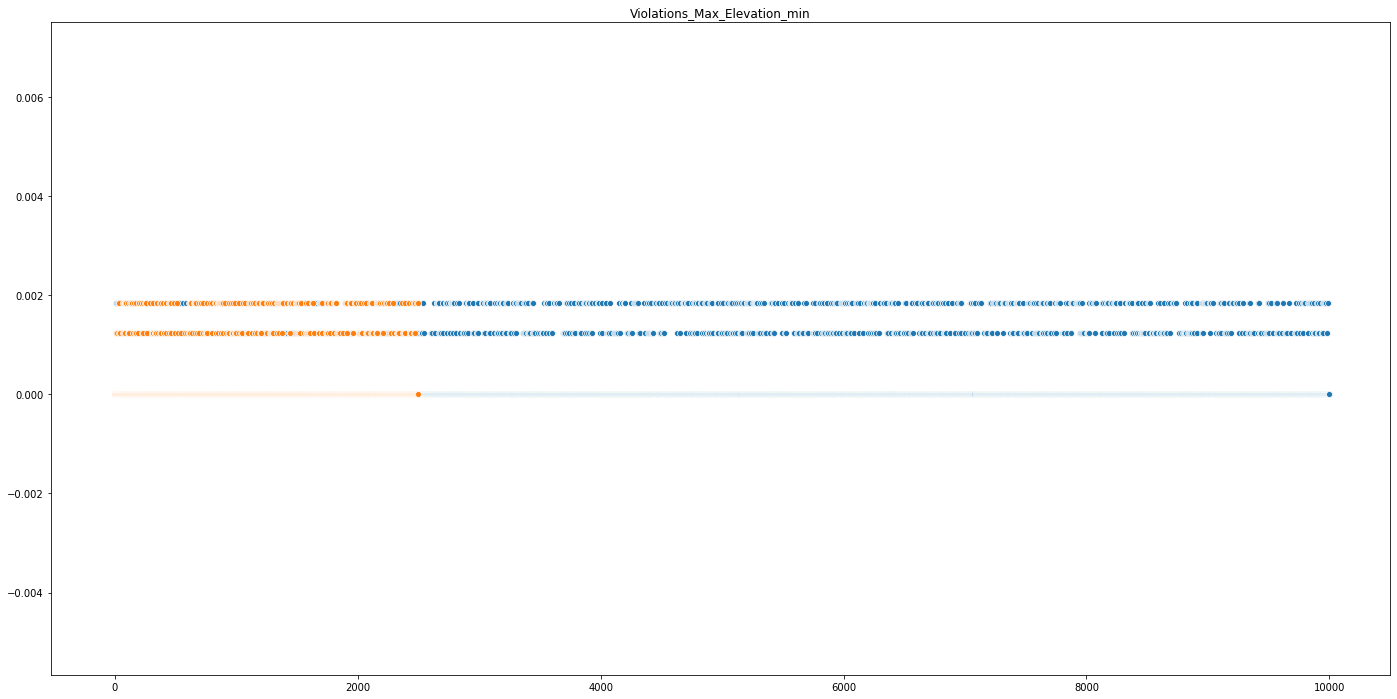

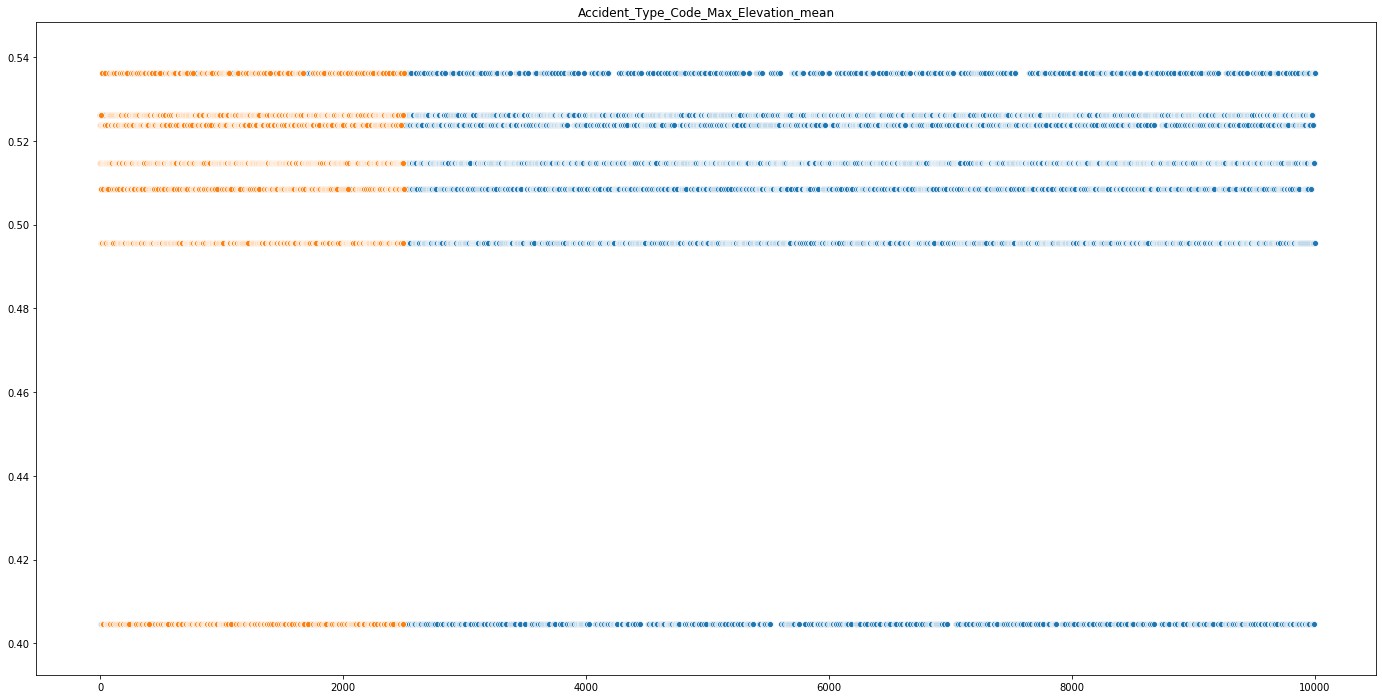

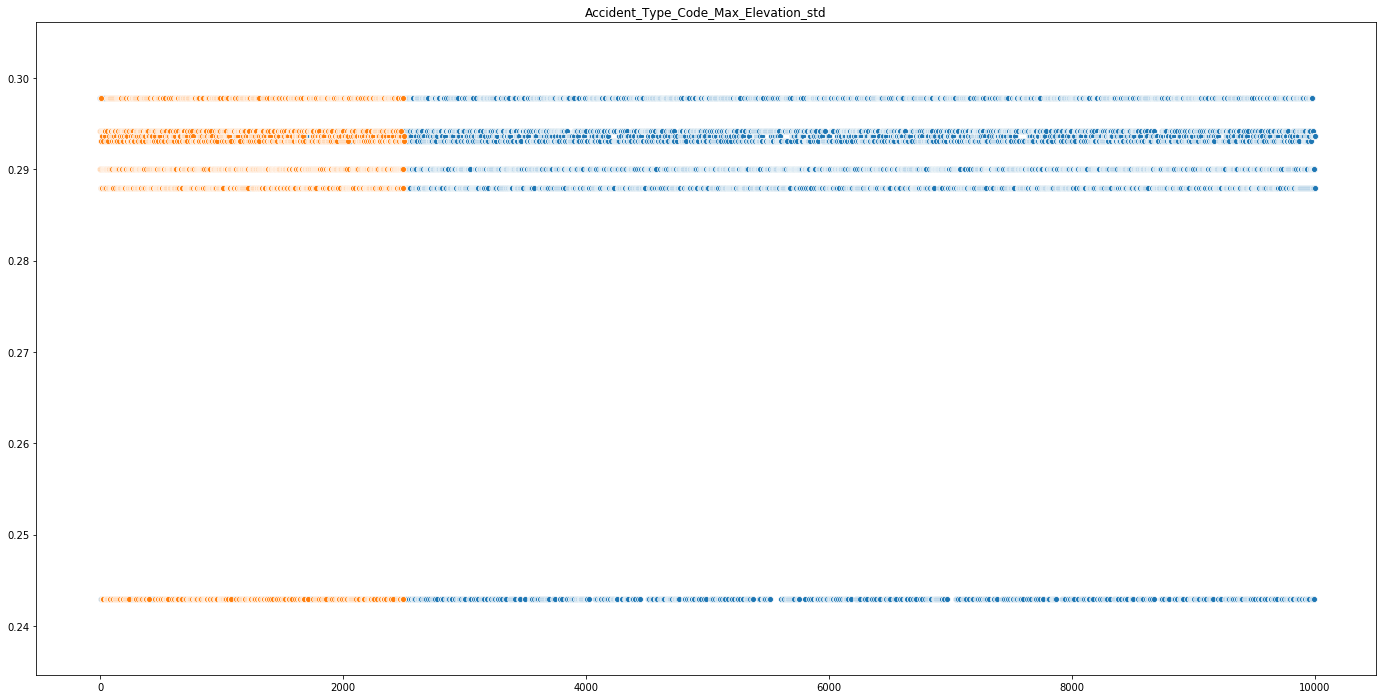

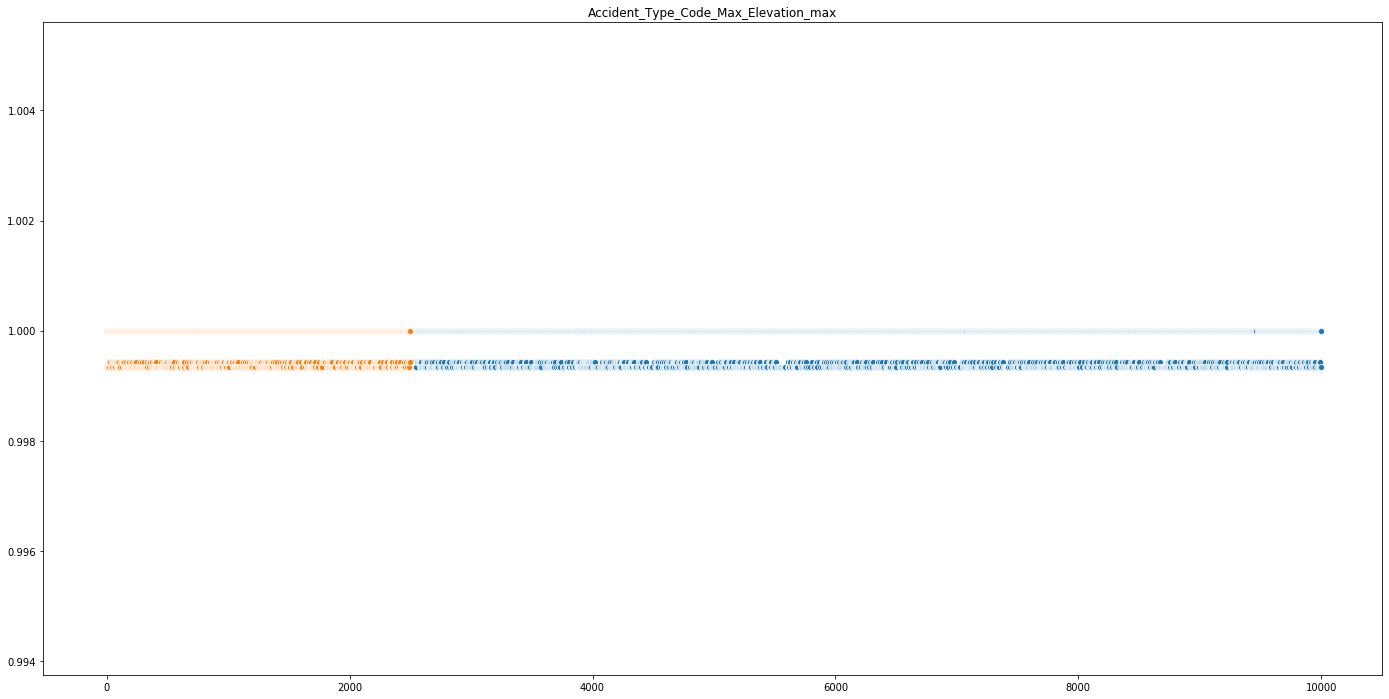

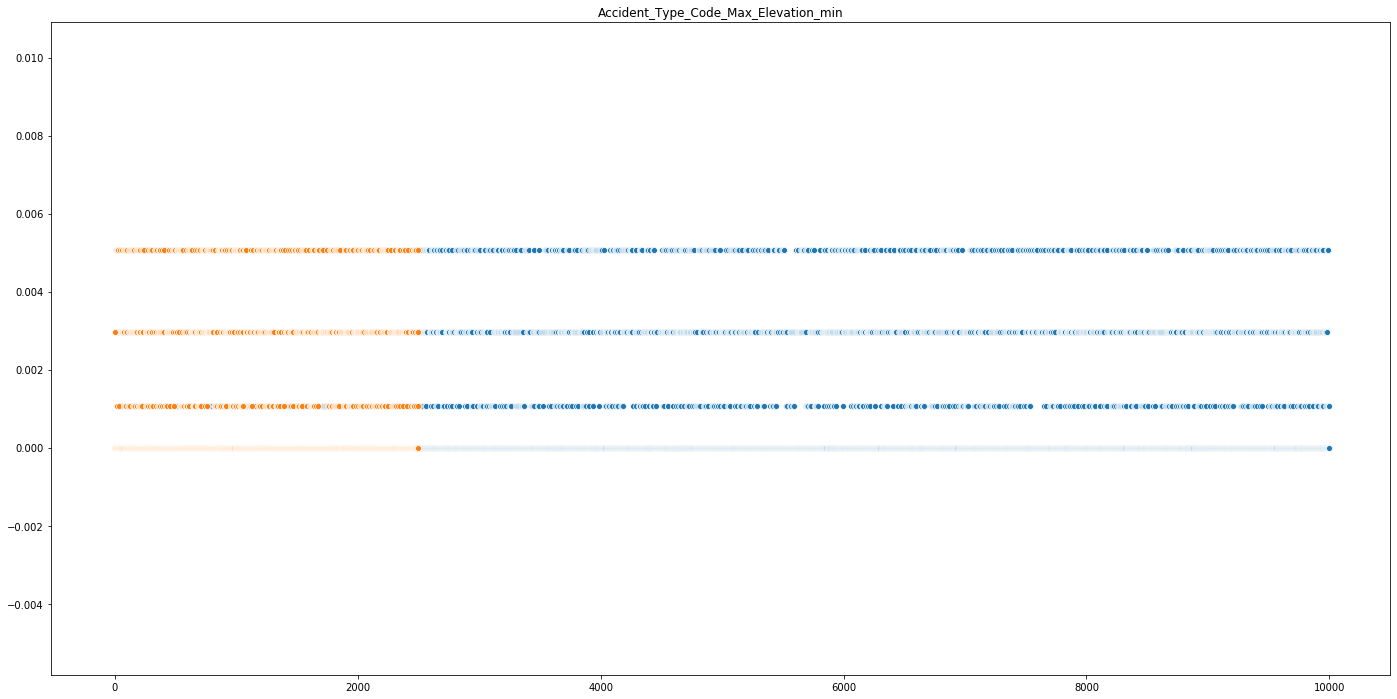

In [56]:
neglect_columns = [param["target"]]
for i in range(2):
    try:
        if param["le_cat_cols"][i] is not None:
            neglect_columns.extend(param["le_cat_cols"][i])
    except:
        pass
    try:
        if param["ohe_cat_cols"][i] is not None:
            neglect_columns.extend(param["ohe_cat_cols"][i])
    except:
        pass
    try:
        if param["id_columns"][i] is not None:
            neglect_columns.extend(param["id_columns"][i])
    except:
        pass
for col in train.columns:
    if col not in neglect_columns:
        plt.figure(figsize=(24,12))
        sns.scatterplot(data=train[col])
        sns.scatterplot(data=test[col])
        plt.title(col)
        plt.show()

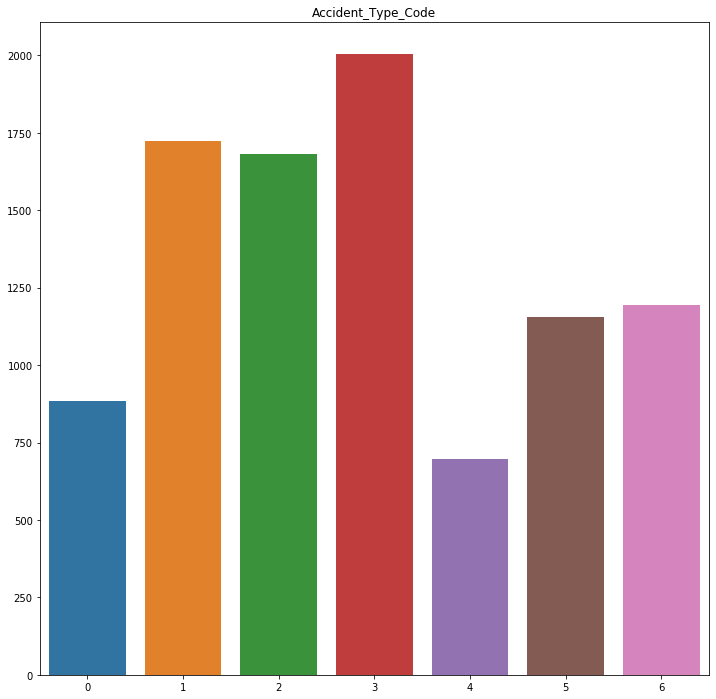

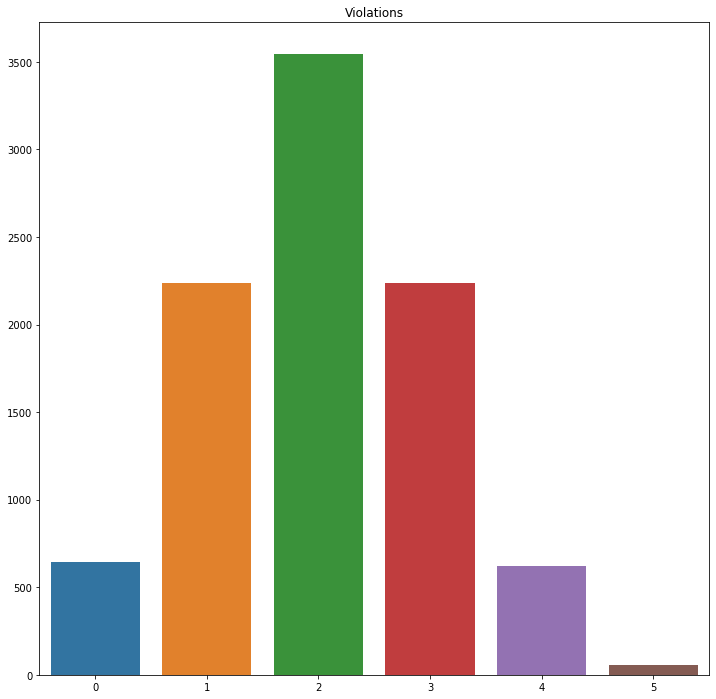

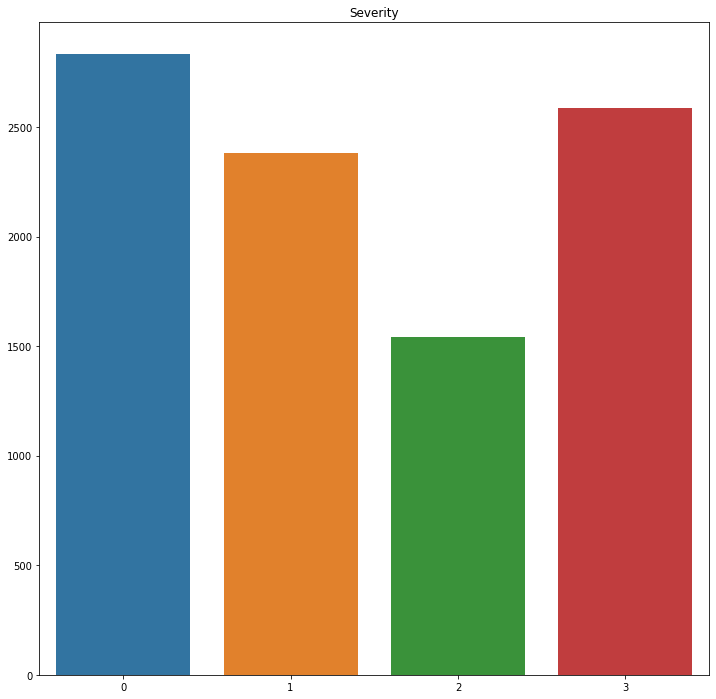

In [57]:
for col in param["le_cat_cols"][0]:
    d = train[col].value_counts()
    plt.figure(figsize=(12,12))
    sns.barplot(x=d.index,y=d.values)
    plt.title(col)
    plt.show()

## Model Building

In [58]:
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC

In [59]:
target = train[param['target']]
to_drop(0)

In [60]:
# pred = []
# for seed in seeds:
#     train_split_x,test_split_x,train_split_y,test_split_y = train_test_split(train,target,test_size=param['validation_split'],random_state=seed)
#     lgb_model = lgb.LGBMClassifier(class_weight=dict(target.value_counts()),objective='multiclassova',n_estimators=2000,random_state=2020)
#     xgb_model = xgb.XGBClassifier(n_estimators=2000,random_state=42)
#     lgb_model.fit(train_split_x,train_split_y)
#     y_pred = lgb_model.predict(test_split_x)
#     print(f1_score(test_split_y,y_pred,average='weighted'))
#     y_pred = np.array(lgb_model.predict_proba(test))
#     pred.append(y_pred)

In [61]:
train_split_x,test_split_x,train_split_y,test_split_y = train_test_split(train,target,test_size=param['validation_split'],random_state=param['seed'])

In [62]:
# pred = np.hstack(pred)

In [63]:
# y_pred = np.argmax(pred,axis=1)%4

In [64]:
lgb_model = lgb.LGBMClassifier(class_weight=dict(target.value_counts()),objective='multiclassova')
# lgb_model = xgb.XGBClassifier(n_estimators=1000,random_state=42,learning_rate=0.1,max_depth=20,objective='multi:softmax')
# cat_model = cb.CatBoostClassifier(iterations=10000,random_seed=42)

In [65]:
param_grid = {'num_leaves': [20,30,50],
              'min_data_in_leaf': [5,10,20],
              'max_depth': [-1,10,20],
              'feature_fraction': [0.8,1.0],
              'learning_rate': [0.1,0.05],
              'num_iterations': [1000,2000,3000],
              'lambda_l2': [0.0,2.0],
              'random_state': [19,2020]}

In [ ]:
grid_search = GridSearchCV(lgb_model, param_grid=param_grid)
grid_search.fit(train_split_x, train_split_y)

In [ ]:
y_pred = grid_search.best_estimator_.predict(test_split_x)
print(f1_score(test_split_y,y_pred,average='weighted'))

In [ ]:
with open('out.txt','w') as f:
    f.write(str(grid_search.best_params_))
    f.close()

In [ ]:
y_pred = np.array(grid_search.best_estimator_.predict(test),dtype=np.uint8)
y_pred = encs[2].inverse_transform(y_pred)
outputs['Severity']=y_pred
pd.DataFrame(outputs).to_csv('output.csv',index=False)

In [ ]:
# lgb_model.fit(train_split_x,train_split_y)

In [ ]:
# cat_model.fit(train_split_x,train_split_y)

In [ ]:
# plt.figure(figsize=(24,16))
# sns.barplot(y=train.columns,x=lgb_model.feature_importances_,orient='h')

In [ ]:
# plt.figure(figsize=(24,16))
# sns.barplot(y=train.columns,x=cat_model.feature_importances_,orient='h')

In [ ]:
# y_pred = lgb_model.predict(test_split_x)

In [ ]:
# print(f1_score(test_split_y,y_pred,average='weighted'))

In [ ]:
# y_pred = np.array(lgb_model.predict(test),dtype=np.uint8)
# y_pred = encs[2].inverse_transform(y_pred)
# outputs['Severity']=y_pred
# pd.DataFrame(outputs).to_csv('output.csv',index=False)

In [ ]:
# y_pred = cat_model.predict(test_split_x)

In [ ]:
# print(f1_score(test_split_y,y_pred,average='weighted'))

In [ ]:
# y_pred = np.array(lgb_model.predict(test),dtype=np.uint8)
# y_pred = encs[2].inverse_transform(y_pred)
# outputs['Severity']=y_pred
# pd.DataFrame(outputs).to_csv('output.csv',index=False)

In [ ]:
# kfold = StratifiedKFold(n_splits=param['folds'],random_state=param['seed'])

In [ ]:
# rf_model = RandomForestClassifier()
# lgb_model = lgb.LGBMClassifier()
# xgb_model = xgb.XGBClassifier()
# cat_model = cat.CatBoostClassifier(verbose=False)

In [ ]:
# pred = []
# for i,(train_ids,test_ids) in enumerate(kfold.split(train_split_x,train_split_y)):
# for train_ids,test_ids in kfold.split(df_train,target):
#     lgb_model = lgb.LGBMClassifier(boosting_type='dart',n_estimators=2000,class_weight=dict(target.value_counts()),random_state=param['seed'])
#     xgb_model = xgb.XGBClassifier(n_estimators=2000,random_state=42)
#     x_train,x_test = train_split_x.iloc[train_ids],train_split_x.iloc[test_ids]
#     y_train,y_test = train_split_y.iloc[train_ids],train_split_y.iloc[test_ids]
#     x_train,x_test = df_train.iloc[train_ids],df_train.iloc[test_ids]
#     y_train,y_test = target[train_ids],target[test_ids]
#     rf_model.fit(x_train,y_train)
#     lgb_model.fit(x_train,y_train)
#     xgb_model.fit(x_train,y_train)
#     cat_model.fit(x_train,y_train)
#     y_pred = rf_model.predict(x_test)
#     print(f1_score(y_test,y_pred,average='weighted'))
#     y_pred = lgb_model.predict(x_test)
#     print(f1_score(y_test,y_pred,average='weighted'))
#     y_pred = xgb_model.predict(x_test)
#     print(f1_score(y_test,y_pred,average='weighted'))
#     y_pred = cat_model.predict(x_test)
#     print(f1_score(y_test,y_pred,average='weighted'))
#     y_pred = (lgb_model.predict_proba(x_test) + cat_model.predict_proba(x_test))/2
#     y_pred = np.argmax(y_pred,axis=1)
#     print(f1_score(y_test,y_pred,average='weighted'))
#     y_pred = lgb_model.predict(test)
#     pred.append(y_pred)
#     y_pred = xgb_model.predict(test)
#     pred.append(y_pred)
#     y_pred = y_pred.reshape(test.shape[0]).astype(int)
#     y_pred = encs[2].inverse_transform(y_pred)
#     outputs['Severity']=y_pred
#     pd.DataFrame(outputs).to_csv(f'submission{i}.csv',index=False)

In [ ]:
# y_pred = np.argmax(np.max(pred,axis=0).reshape((test.shape[0],param['num_class'])),axis=1)

In [ ]:
# pred = np.vstack(pred)

In [ ]:
# y_pred = []
# for i in range(len(pred[0])):
#     unique,counts = np.unique(pred[:,i],return_counts=True)
#     max_count = 0
#     out = 1
#     for u,c in zip(unique,counts):
#         if c > max_count:
#             max_count = c
#             out = u
#     y_pred.append(out)

In [ ]:
# y_pred = encs[2].inverse_transform(y_pred)
# outputs['Severity']=y_pred
# pd.DataFrame(outputs).to_csv(f'output.csv',index=False)

In [ ]:
# cat_model.fit(train_split_x,train_split_y,verbose=False)

In [ ]:
# # y_pred = rf_model.predict(test_split_x)
# # print(f1_score(test_split_y,y_pred,average='weighted'))
# y_pred = cat_model.predict(test_split_x)
# print(f1_score(test_split_y,y_pred,average='weighted'))
# # y_pred = xgb_model.predict(test_split_x)
# # print(f1_score(test_split_y,y_pred,average='weighted'))
# y_pred = cat_model.predict(test_split_x)
# print(f1_score(test_split_y,y_pred,average='weighted'))

In [ ]:
# y_pred = (lgb_model.predict_proba(test_split_x) + cat_model.predict_proba(test_split_x))/2
# y_pred = np.argmax(y_pred,axis=1)
# print(f1_score(test_split_y,y_pred,average='weighted'))

In [ ]:
# y_pred = lgb_model.predict(test)
# y_pred = y_pred.reshape(test.shape[0]).astype(int)

In [ ]:
# y_pred = (lgb_model.predict_proba(test) + cat_model.predict_proba(test))/2
# y_pred = np.argmax(y_pred,axis=1)

In [ ]:
# y_pred = encs[2].inverse_transform(y_pred)

In [ ]:
# outputs['Severity']=y_pred

In [ ]:
# pd.DataFrame(outputs).to_csv('submission1.csv',index=False)

In [ ]:
# plt.figure(figsize=(24,12))
# sns.barplot(y=cat_model.feature_names_,x=cat_model.feature_importances_,orient='h')

In [ ]:
# plt.figure(figsize=(24,16))
# sns.barplot(y=train.columns,x=lgb_model.feature_importances_,orient='h')

In [ ]:
# reduce_train, reduce_test, categoricals = get_train_and_test(train, test)
# call feature engineering function
# reduce_train, reduce_test, features = preprocess(reduce_train, reduce_test)

In [ ]:
# train.columns

In [ ]:
# train.describe()

In [ ]:
# num_leaves
# min_data_in_leaf
# max_depth
# bagging_fraction
# bagging_freq
# feature_fraction
# max_bin
# save_binary
# learning_rate
# num_iterations
# objective
# num_class
# boosting
# tree_learner
# num_threads
# device_type

# force_col_wise
# force_row_wise
# min_sum_hessian_in_leaf
# pos_bagging_fraction
# neg_bagging_fraction
# feature_fraction_bynode
# early_stopping_round
# max_delta_step
# lambda_l1
# lambda_l2
# min_gain_to_split
# drop_rate
# max_drop
# skip_drop
# xgboost_dart_mode
# uniform_drop
# drop_seed
# top_rate
# other_rate
# min_data_per_group
# max_cat_threshold
# cat_l2
# cat_smooth
# max_cat_to_onehot
# top_k
# monotone_constraints
# feature_contri


# bagging_seed
# feature_fraction_seed
# seed

# verbose

# metric
# metric_freq
# is_provide_training_metric
# eval_at
# multi_error_top_k
# auc_mu_weights